# Setup

In [1]:
from idrtools import math
from twins_embedding import TwinsEmbeddingAnalysis
from matplotlib import pyplot as plt
from matplotlib import colors
from tqdm.notebook import tqdm
from astropy.table import Table
import utils
import numpy as np

/home/kyle/supernova/snfactory/manifold_twins/analysis/twins_embedding.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
%matplotlib inline

In [3]:
a = TwinsEmbeddingAnalysis()
a.settings['figure_directory'] = './output_generation/figures/'
a.settings['latex_directory'] = './output_generation/latex/'
a.run_analysis()

Loading dataset...
    IDR:          BLACKSTON
    Phase range: [-5.0, 5.0] days
    Bin velocity: 1000.0



Estimating the spectra at maximum light...
    Loaded cached stan model
    Using saved stan result
Reading between the lines...
    Loaded cached stan model
    Using saved stan result
Building masks...
    Masking 30/203 targets whose uncertainty power is 
    more than 0.100 of the intrinsic power.
Generating the manifold learning embedding...
Loading other indicators of diversity...


/home/kyle/packages/conda/lib/python3.8/site-packages/numpy/ma/core.py:2794: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,
/home/kyle/packages/conda/lib/python3.8/site-packages/george/kernels.py:95: RuntimeWarning: divide by zero encountered in log
  log_constant = np.log(float(b)/self.ndim)


Fitting RBTL Twins Manifold GP...
GP magnitude residuals fit:
    Fit result:           b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
    intrinsic_dispersion      0.073 ± 0.008
    gp_kernel_amplitude       0.164 ± 0.082
    gp_length_scale           5.541 ± 3.315
    offset                    -0.116 ± 0.124
    covariate_slope_0         -0.122 ± 0.051
    Fit NMAD                  0.083 mag
    Fit std                   0.101 mag
Fitting SALT2 Twins Manifold GP...
GP magnitude residuals fit:
    Fit result:           b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
    intrinsic_dispersion      0.085 ± 0.010
    gp_kernel_amplitude       0.380 ± 0.231
    gp_length_scale           8.631 ± 5.329
    offset                    6.956 ± 0.299
    covariate_slope_0         2.810 ± 0.153
    Fit NMAD                  0.105 mag
    Fit std                   0.118 mag
Calculating SALT2 magnitude residuals...
SALT2 magnitude residuals fit: 
    ref_mag: 7.051
    alpha:   0.148
    beta

# Estimating the spectra at maximum light

## Examples of maximum light models

In [4]:
phase_cmap = plt.cm.ScalarMappable(
    norm=plt.Normalize(vmin=-5, vmax=5),
    cmap=colors.LinearSegmentedColormap.from_list('phase_cmap', plt.cm.plasma(np.linspace(0., 0.9, 100)))
)

def get_time_evolution_data(idx):
    fluxes = a.flux[a.target_map == idx]
    phases = a.salt_phases[a.target_map == idx]
    model = a.differential_evolution_result['maximum_flux'][idx]
    model_err = a.differential_evolution_result['maximum_fluxerr'][idx]
    gray_offsets = a.differential_evolution_result['gray_offsets'][a.target_map == idx]
    model_diffs = a.differential_evolution_result['model_diffs'][a.target_map == idx]
    
    return fluxes, phases, model, model_err, gray_offsets, model_diffs

def plot_time_evolution_model(idx, ax=None, skip_same_night=False):
    if ax is None:
        fig, ax = plt.subplots(figsize=a.settings['spectrum_plot_figsize'])
    fluxes, phases, model, model_err, gray_offsets, model_diffs = get_time_evolution_data(idx)

    last_phase = None
    for flux, phase in zip(fluxes, phases):
        if skip_same_night and last_phase is not None and phase - last_phase < 0.5:
            # Same night, skip it
            continue
        last_phase = phase
        a.plot_flux(ax, flux, label='Data (%.2f days)' % phase, c=phase_cmap.to_rgba(phase))
    a.plot_flux(ax, model, model_err, c='k', ls='--', label='Model (0 days)', uncertainty_label='Model Uncertainty')
    ax.legend()
    ax.set_title(a.targets[idx])
    
def plot_time_evolution_difference(idx, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=a.settings['spectrum_plot_figsize'])
    fluxes, phases, model, model_err, gray_offsets, model_diffs = get_time_evolution_data(idx)

    phase_slope = a.differential_evolution_result['phase_slope']
    phase_quadratic = a.differential_evolution_result['phase_quadratic']
    gray_offsets = a.differential_evolution_result['gray_offsets'][a.target_map == idx]
    model_diffs = a.differential_evolution_result['model_diffs'][a.target_map == idx]

    for i, (flux, phase, gray_offset, model_diff) in enumerate(zip(fluxes, phases, gray_offsets, model_diffs)):
        ax.plot(a.wave, -2.5*np.log10(flux / model), label='Data (%.2f days)' % phase, c=phase_cmap.to_rgba(phase))
    for i, (flux, phase, gray_offset, model_diff) in enumerate(zip(fluxes, phases, gray_offsets, model_diffs)):
        ax.plot(a.wave, model_diff, label='Model (%.2f days)' % phase, c=phase_cmap.to_rgba(phase), ls='--')
    ax.legend(ncol=2, loc=1)
    ax.set_title(a.targets[idx])
    ax.set_xlabel(a.settings['spectrum_plot_xlabel'])
    ax.set_ylabel('Difference from\nmaximum light (mag)')

def plot_time_evolution_residuals(idx, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=a.settings['spectrum_plot_figsize'])
    fluxes, phases, model, model_err, gray_offsets, model_diffs = get_time_evolution_data(idx)
    
    # Plot the interpolation residuals
    for i, (flux, phase, model_diff) in enumerate(zip(fluxes, phases, model_diffs)):
        ax.plot(a.wave, -2.5*np.log10(flux / model) - model_diff, label='Residuals (%.2f days)' % phase,
                c=phase_cmap.to_rgba(phase))
    ax.legend()
    ax.set_title(a.targets[idx])
    ax.set_xlabel(a.settings['spectrum_plot_xlabel'])
    ax.set_ylabel('Interpolation residuals (mag)')
    
def plot_same_night(idx):
    plot_time_evolution_model(idx)
    plot_time_evolution_difference(idx)
    plot_time_evolution_residuals(idx)

from ipywidgets import interact
interact(plot_same_night, idx=(0, len(a.targets)-1))

interactive(children=(IntSlider(value=101, description='idx', max=202), Output()), _dom_classes=('widget-inter…

<function __main__.plot_same_night(idx)>

In [5]:
# Out of sample reconstruction test
def plot_oos_reconstruction(idx, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=a.settings['spectrum_plot_figsize'])
    fluxes, phases, model, model_err, gray_offsets, model_diffs = get_time_evolution_data(idx)

    phase_slope = a.differential_evolution_result['phase_slope']
    phase_quadratic = a.differential_evolution_result['phase_quadratic']
    gray_offsets = a.differential_evolution_result['gray_offsets'][a.target_map == idx]
    model_diffs = a.differential_evolution_result['model_diffs'][a.target_map == idx]

    for i, (flux, phase, gray_offset, model_diff) in enumerate(zip(fluxes, phases, gray_offsets, model_diffs)):
        ax.plot(a.wave, -2.5*np.log10(flux / model), label='Data (%.2f days)' % phase, c='C%d' % i)
    for i, (flux, phase, gray_offset, model_diff) in enumerate(zip(fluxes, phases, gray_offsets, model_diffs)):
        ax.plot(a.wave, model_diff, label='Model (%.2f days)' % phase, c='C%d' % i, ls='--')
    ax.legend(ncol=2, loc=1)
    ax.set_title(a.targets[idx])
    ax.set_xlabel(a.settings['spectrum_plot_xlabel'])
    ax.set_ylabel('Difference from\nmaximum light (mag)')

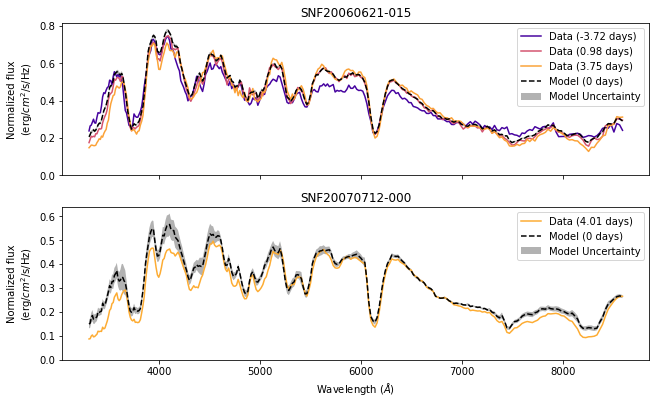

In [6]:
# plot_targets = ['PTF13ayw', 'SN2004gc']
plot_targets = ['SNF20060621-015', 'SNF20070712-000']

figsize = a.settings['spectrum_plot_figsize_double']
fig, axes = plt.subplots(2, 1, figsize=figsize, sharex=True)

for ax, plot_target in zip(axes, plot_targets):
    target_names = np.array([i.name for i in a.targets])
    plot_idx = np.where(target_names == plot_target)[0][0]

    plot_time_evolution_model(plot_idx, ax, skip_same_night=True)

for ax in axes[:-1]:
    ax.set_xlabel(None)

a.savefig('time_evolution_model.pdf', fig)

## Differential time evolution model

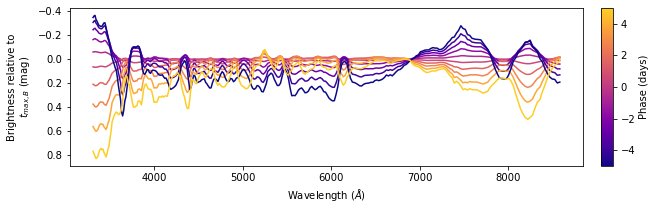

In [7]:
phase_slope = a.differential_evolution_result['phase_slope']
phase_quadratic = a.differential_evolution_result['phase_quadratic']
phase_slope_x1 = a.differential_evolution_result['phase_slope_x1']
phase_quadratic_x1 = a.differential_evolution_result['phase_quadratic_x1']

def evaluate_phase_difference(phase, x1=0):
    phase_difference = (
        phase_slope * phase
        + phase_quadratic * phase * phase
        + phase_slope_x1 * x1 * phase
        + phase_quadratic_x1 * x1 * phase * phase
    )
    
    return phase_difference

# Look at change in phase for the same x1
max_phase = a.settings['phase_range']
min_phase = -a.settings['phase_range']
num_phases = 10
phases = np.linspace(min_phase, max_phase, num_phases)

fig, ax = plt.subplots(figsize=a.settings['spectrum_plot_figsize'])

for phase in phases:
    ax.plot(a.wave, evaluate_phase_difference(phase), c=phase_cmap.to_rgba(phase), zorder=np.abs(phase))

fig.colorbar(phase_cmap, ax=ax, orientation='vertical', label='Phase (days)', aspect=40)

ax.set_xlabel(a.settings['spectrum_plot_xlabel'])
ax.set_ylabel('Brightness relative to\n$t_{max,B}$ (mag)')
ax.invert_yaxis()

a.savefig('time_evolution_phase_difference.pdf', fig)

In [8]:
# SALT2 x1 difference plots. This only makes sense if we are including x1 in the
# differential evolution model, so these are blank with the default settings.
# I only make them if x1 was actually used.

def plot_x1_difference(phase):
    # Look at change in phase for the same x1
    min_x1 = -2
    max_x1 = 2
    num_x1s = 10
    x1s = np.linspace(min_x1, max_x1, num_x1s)

    fig, ax = plt.subplots(figsize=a.settings['spectrum_plot_figsize'])
    norm = plt.Normalize(vmin=min_x1, vmax=max_x1)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(x1s)

    for x1 in x1s:
        diff = evaluate_phase_difference(phase, x1) - evaluate_phase_difference(phase, 0)
        ax.plot(a.wave, diff, c=cmap(norm(x1)))

    fig.colorbar(sm, label='SALT2 $x_1$')

    ax.set_xlabel(a.settings['spectrum_plot_xlabel'])
    ax.set_ylabel('Difference relative to $x_1=0$ (mag)')
    ax.set_title('Difference in interpolation at %+d days' % phase)
    ax.set_ylim(0.4, -0.4)
    a.savefig('time_evolution_x1_difference_phase_%d.pdf' % phase, fig)

if a.settings['differential_evolution_use_salt_x1']:
    for phase in [-5, -3, -1, 1, 3, 5]:
        plot_x1_difference(phase)

## Gray dispersion

Gray dispersion scale: 0.0296 mag


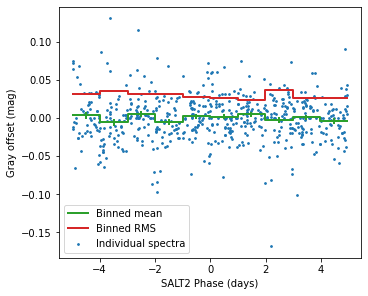

In [9]:
# Check if the gray dispersion is phase dependent. This should not be the
# case if the model is working properly.
gray_scale = a.differential_evolution_result['gray_dispersion_scale']
print(f"Gray dispersion scale: {gray_scale:.4f} mag")

plt.figure()
gray_offsets = a.differential_evolution_result['gray_offsets']
plt.scatter(a.salt_phases, gray_offsets, s=3, label='Individual spectra')
math.plot_binned_mean(a.salt_phases, gray_offsets, c='C2', lw=2, label='Binned mean')
math.plot_binned_rms(a.salt_phases, gray_offsets, c='C3', lw=2, label='Binned RMS')
plt.xlabel('SALT2 Phase (days)')
plt.ylabel('Gray offset (mag)')
plt.legend()
a.savefig('gray_offset_vs_phase.pdf')

(-0.1, 0.1)

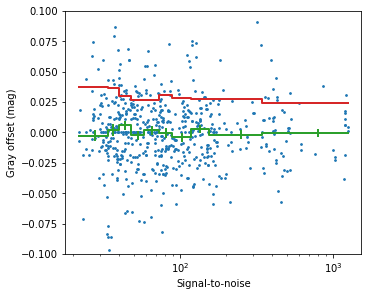

In [10]:
plt.figure()
s2n = np.array([np.median(i.flux / i.fluxerr) for i in a.spectra])
plt.scatter(s2n, gray_offsets, s=3, label='Individual spectra')
math.plot_binned_mean(s2n, gray_offsets, equal_bin_counts=True, c='C2', lw=2, label='Binned mean')
math.plot_binned_rms(s2n, gray_offsets, equal_bin_counts=True, c='C3', lw=2, label='Binned RMS')
plt.xlabel('Signal-to-noise')
plt.ylabel('Gray offset (mag)')
plt.xscale('log')
plt.ylim(-0.1, 0.1)

## Differential evolution uncertainty

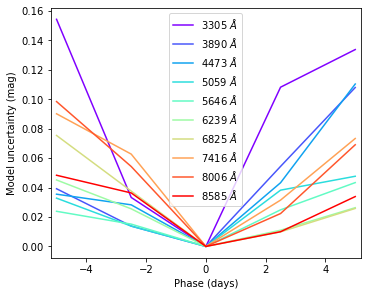

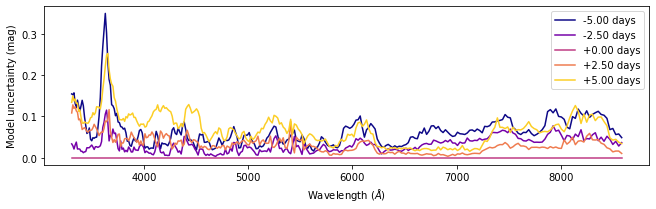

In [11]:
coefs = a.differential_evolution_result['phase_dispersion_coefficients']
num_phase_coefficients = len(coefs)

phase_range = a.settings['phase_range']

def evaluate_phase_dispersion(phase):
    phase_scale = np.abs((num_phase_coefficients / 2) * (phase / phase_range))
    full_bins = int(np.floor(phase_scale))
    remainder = phase_scale - full_bins

    phase_coefficients = np.zeros(num_phase_coefficients)

    for j in range(full_bins + 1):
        if j == full_bins:
            weight = remainder
        else:
            weight = 1

        if weight == 0:
            break

        if phase > 0:
            phase_bin = num_phase_coefficients // 2 + j
        else:
            phase_bin = num_phase_coefficients // 2 - 1 - j
            
        phase_coefficients[phase_bin] = weight
        
    fractional_dispersion = phase_coefficients.dot(coefs)
    
    # Convert to magnitudes
    mag_dispersion = utils.frac_to_mag(fractional_dispersion)

    return mag_dispersion

phases = np.linspace(-phase_range, phase_range, 1 + num_phase_coefficients)

eval_coefs = np.array([evaluate_phase_dispersion(phase) for phase in phases])

# Uncertainties for different wavelengths
plt.figure()
num_wave = 10
for i in range(num_wave):
    min_wave = a.wave[0]
    max_wave = a.wave[-1]
    wave_range = max_wave - min_wave
    target_wave = min_wave + wave_range * i / (num_wave - 1)
    idx = np.argmin(np.abs(a.wave - target_wave))
    use_wave = a.wave[idx]
    color = plt.cm.rainbow((use_wave - min_wave) / wave_range)
    plt.plot(phases, eval_coefs[:, idx], label='%d $\AA$' % use_wave, c=color)
    
plt.xlim(-5.2, 5.2)
plt.xlabel('Phase (days)')
plt.ylabel('Model uncertainty (mag)')
plt.legend()
a.savefig('time_evolution_uncertainty_phase.pdf')

plt.figure(figsize=a.settings['spectrum_plot_figsize'])
for i in range(len(phases)):
    plt.plot(a.wave, eval_coefs[i], label='%+.2f days' % phases[i], c=phase_cmap.to_rgba(phases[i]))
plt.legend()
plt.xlabel(a.settings['spectrum_plot_xlabel'])
plt.ylabel('Model uncertainty (mag)')
a.savefig('time_evolution_uncertainty_wavelength.pdf')

In [12]:
np.median(a.maximum_uncertainty_fraction[a.uncertainty_mask])

0.02223002696765615

## Model accuracy

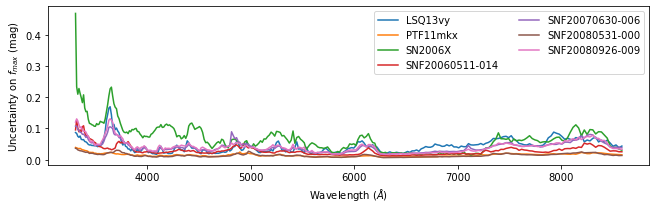

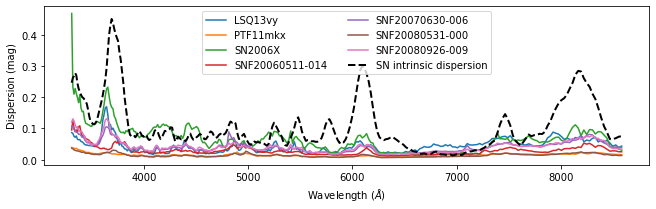

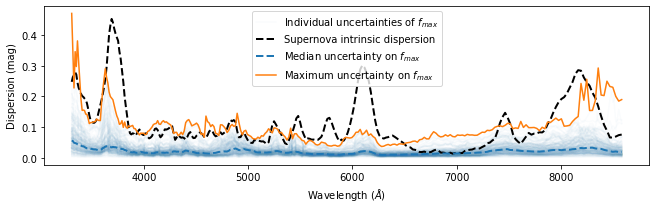

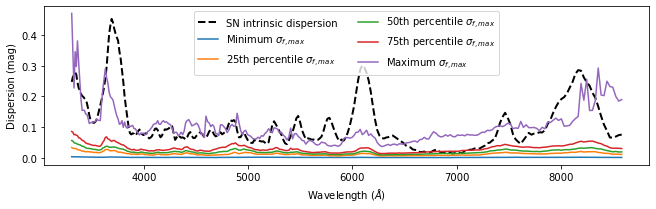

In [13]:
max_flux = a.differential_evolution_result['maximum_flux']
max_fluxerr = a.differential_evolution_result['maximum_fluxerr']

max_magerr = utils.frac_to_mag(max_fluxerr / max_flux)

rbtl_dispersion = utils.frac_to_mag(a.rbtl_result['fractional_dispersion'])

def plot_uncertainties(show_rbtl=False):
    plt.figure(figsize=a.settings['spectrum_plot_figsize'])
    offset = 29
    
    # Make sure that we include the worst offender.
    max_loc = np.argmax(np.sum(max_magerr**2, axis=1))
    start = max_loc % offset
    
    for idx in range(start, len(a.targets), offset):
        plt.plot(a.wave, max_magerr[idx], label=a.targets[idx].name)
    plt.legend(ncol=2)
    
    plt.xlabel('Wavelength ($\AA$)')
    
    if show_rbtl:
        plt.plot(a.wave, rbtl_dispersion, label='SN intrinsic dispersion', c='k', lw=2, ls='--')
        plt.ylabel('Dispersion (mag)')
        filename = 'maximum_uncertainty_rbtl.pdf'
    else:
        plt.ylabel('Uncertainty on $f_{max}$ (mag)')
        filename = 'maximum_uncertainty_norbtl.pdf'
        
    plt.legend(ncol=2)
    a.savefig(filename)

plot_uncertainties(False)
plot_uncertainties(True)


plt.figure(figsize=a.settings['spectrum_plot_figsize'])
for idx in range(len(a.targets)):
    if idx == 0:
        label = 'Individual uncertainties of $f_{max}$'
    else:
        label = ''
    plt.plot(a.wave, max_magerr[idx], label=label, alpha=0.02, c='C0')
plt.plot(a.wave, rbtl_dispersion, label='Supernova intrinsic dispersion', lw=2, ls='--', c='k')
plt.plot(a.wave, np.median(max_magerr, axis=0), label='Median uncertainty on $f_{max}$', lw=2, ls='--', c='C0')
plt.plot(a.wave, np.max(max_magerr, axis=0), label='Maximum uncertainty on $f_{max}$', c='C1')
plt.legend()
plt.ylabel('Dispersion (mag)')
plt.xlabel('Wavelength ($\AA$)')
a.savefig('maximum_uncertainty_median.pdf')

plt.figure(figsize=a.settings['spectrum_plot_figsize'])
plt.plot(a.wave, rbtl_dispersion, label='SN intrinsic dispersion', lw=2, ls='--', c='k')
plt.plot(a.wave, np.min(max_magerr, axis=0), label='Minimum $\sigma_{f,max}$')
for percentile in (25, 50, 75):
    plt.plot(a.wave, np.percentile(max_magerr, percentile, axis=0), label='%dth percentile $\sigma_{f,max}$' % percentile)
plt.plot(a.wave, np.max(max_magerr, axis=0), label='Maximum $\sigma_{f,max}$')
plt.legend(ncol=2)
plt.ylabel('Dispersion (mag)')
plt.xlabel('Wavelength ($\AA$)')
a.savefig('maximum_uncertainty_percentile.pdf')

## Contribution to the total interpolation uncertainty from various sources

Interpolation of 0.0-1.5 days:
                 Raw: std=0.052, NMAD=0.039
               Phase: std=0.045, NMAD=0.034
          Phase + x1: std=0.045, NMAD=0.034
        Phase + gray: std=0.029, NMAD=0.014
   Phase + x1 + gray: std=0.029, NMAD=0.014

Interpolation of 1.5-2.5 days:
                 Raw: std=0.115, NMAD=0.087
               Phase: std=0.080, NMAD=0.066
          Phase + x1: std=0.080, NMAD=0.066
        Phase + gray: std=0.061, NMAD=0.042
   Phase + x1 + gray: std=0.061, NMAD=0.042

Interpolation of 2.5-5.5 days:
                 Raw: std=0.178, NMAD=0.126
               Phase: std=0.094, NMAD=0.075
          Phase + x1: std=0.094, NMAD=0.075
        Phase + gray: std=0.081, NMAD=0.055
   Phase + x1 + gray: std=0.081, NMAD=0.055

Interpolation of 5.5-10.5 days:
                 Raw: std=0.272, NMAD=0.209
               Phase: std=0.128, NMAD=0.098
          Phase + x1: std=0.128, NMAD=0.098
        Phase + gray: std=0.108, NMAD=0.076
   Phase + x1 + gray: std=0.108, NMA

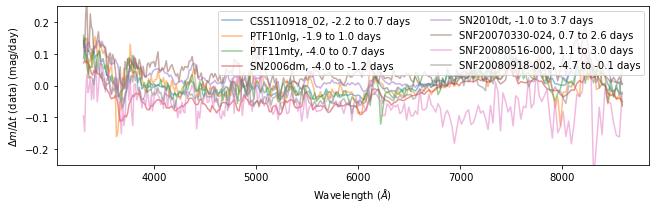

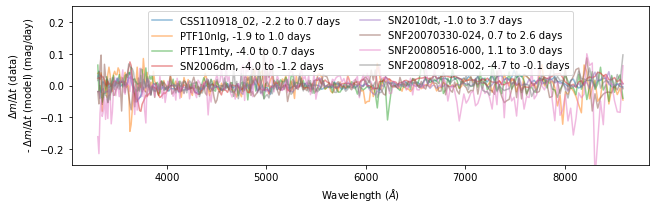

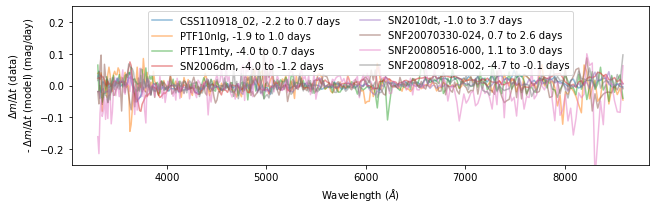

In [14]:
targets = []
diffs = []
phases_1 = []
phases_2 = []
x1s = []
gray_differences = []

gray_offsets = a.differential_evolution_result['gray_offsets']

center_specs = a.spectra[a.center_mask]
center_gray_offsets = gray_offsets[a.center_mask]
for target_idx in range(len(a.targets)):
    near_max_spec = center_specs[target_idx]
    
    target_mask = (a.target_map == target_idx) & (~a.center_mask)
    target_specs = a.spectra[target_mask]
    target_gray_offsets = gray_offsets[target_mask]
    
    for spec_idx, target_spec in enumerate(target_specs):
        phase_diff = target_spec.phase - near_max_spec.phase
        # if np.abs(phase_diff) < 1:
            # continue

        targets.append(a.targets[target_idx])
        diff = -2.5*np.log10(target_spec.flux / near_max_spec.flux)
        diffs.append(diff)
        phases_1.append(near_max_spec.phase)
        phases_2.append(target_spec.phase)
        x1s.append(a.salt_x1[target_idx])
        
        gray_differences.append(target_gray_offsets[spec_idx] - center_gray_offsets[target_idx])

targets = np.array(targets)
diffs = np.array(diffs)
phases_1 = np.array(phases_1)
phases_2 = np.array(phases_2)
x1s = np.array(x1s)
gray_differences = np.array(gray_differences)

phase_diffs = phases_2 - phases_1

def plot_diffs(diffs, model_subtracted=False):
    sel_mask = np.zeros(len(diffs), dtype=bool)
    sel_mask[4::50] = True
    sel_mask[np.abs(phase_diffs) < 1] = False
    
    plt.figure(figsize=a.settings['spectrum_plot_figsize'])
    
    for use_idx in np.where(sel_mask)[0]:
        target = targets[use_idx]
        phase_1 = phases_1[use_idx]
        phase_2 = phases_2[use_idx]
        
        if phase_1 > phase_2:
            phase_1, phase_2 = phase_2, phase_1
        
        label = '%s, %.1f to %.1f days' % (target, phase_1, phase_2)
        
        plt.plot(a.wave, diffs[use_idx] / phase_diffs[use_idx], alpha=0.5, label=label)
        
    plt.legend(ncol=2)

    plt.ylim(-0.25, 0.25)
    plt.xlabel('Wavelength ($\AA$)')
    if model_subtracted:
        plt.ylabel('$\Delta m / \Delta t$ (data)\n - $\Delta m / \Delta t$ (model) (mag/day)')
    else:
        plt.ylabel('$\Delta m / \Delta t$ (data) (mag/day)')

plot_diffs(diffs)
a.savefig('raw_phase_difference.pdf')

residuals_no_x1 = []
residuals_x1 = []
for diff, phase_1, phase_2, x1 in zip(diffs, phases_1, phases_2, x1s):
    model_no_x1 = evaluate_phase_difference(phase_2, 0) - evaluate_phase_difference(phase_1, 0)
    model_x1 = evaluate_phase_difference(phase_2, x1) - evaluate_phase_difference(phase_1, x1)
    residuals_no_x1.append(diff - model_no_x1)
    residuals_x1.append(diff - model_x1)
    
residuals_no_x1 = np.array(residuals_no_x1)
residuals_x1 = np.array(residuals_x1)

residuals_gray_no_x1 = residuals_no_x1 - gray_differences[:, None]
residuals_gray_x1 = residuals_x1 - gray_differences[:, None]

plot_diffs(residuals_gray_no_x1, True)
a.savefig('corr_phase_difference_no_x1.pdf')

plot_diffs(residuals_gray_x1, True)
a.savefig('corr_phase_difference_x1.pdf')

def print_interpolation_residuals(min_days, max_days):
    cut = (np.abs(phase_diffs) < max_days) & (np.abs(phase_diffs) > min_days)

    def do_print(label, vals, cut):
        cut_vals = vals[cut]
        print('%20s: std=%.3f, NMAD=%.3f' % (label, math.rms(cut_vals), math.nmad(cut_vals)))

    print("Interpolation of %.1f-%.1f days:" % (min_days, max_days))
    do_print('Raw', diffs, cut)    
    do_print('Phase', residuals_no_x1, cut)    
    do_print('Phase + x1', residuals_x1, cut)    
    do_print('Phase + gray', residuals_gray_no_x1, cut)    
    do_print('Phase + x1 + gray', residuals_gray_x1, cut)    
    print("")
    
print_interpolation_residuals(0., 1.5)
print_interpolation_residuals(1.5, 2.5)
print_interpolation_residuals(2.5, 5.5)
print_interpolation_residuals(5.5, 10.5)

## What fraction of the interpolation uncertainty is common?

<ipython-input-15-bd488f3d2726>:21: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(phases, residual_dispersion**2 / (residual_dispersion**2 + common_dispersion**2), label='Fraction of dispersion remaining')
<ipython-input-15-bd488f3d2726>:26: RuntimeWarning: invalid value encountered in true_divide
  print("Median fraction of variance explained: %.3f" % (1 - np.nanmedian(residual_dispersion**2 / (residual_dispersion**2 + common_dispersion**2))))


Median fraction of variance explained: 0.846


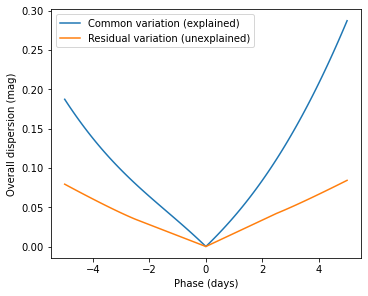

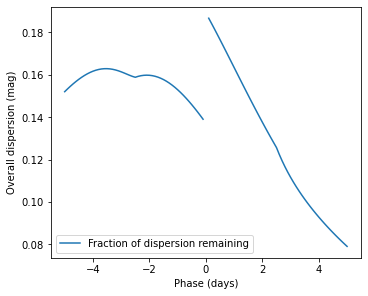

In [15]:
phases = np.linspace(-5, 5, 101)

common_dispersion = []
residual_dispersion = []

for phase in phases:
    common_dispersion.append(np.sqrt(np.mean(evaluate_phase_difference(phase)**2)))
    residual_dispersion.append(np.sqrt(np.mean(evaluate_phase_dispersion(phase)**2)))
    
common_dispersion = np.array(common_dispersion)
residual_dispersion = np.array(residual_dispersion)
    
plt.figure()
plt.plot(phases, common_dispersion, label='Common variation (explained)')
plt.plot(phases, residual_dispersion, label='Residual variation (unexplained)')
plt.legend()
plt.xlabel('Phase (days)')
plt.ylabel('Overall dispersion (mag)')

plt.figure()
plt.plot(phases, residual_dispersion**2 / (residual_dispersion**2 + common_dispersion**2), label='Fraction of dispersion remaining')
plt.legend()
plt.xlabel('Phase (days)')
plt.ylabel('Overall dispersion (mag)')

print("Median fraction of variance explained: %.3f" % (1 - np.nanmedian(residual_dispersion**2 / (residual_dispersion**2 + common_dispersion**2))))

## Test applying the model from a single spectrum to another.

Text(0.5, 1.0, 'Reference phase: 0.71 days')

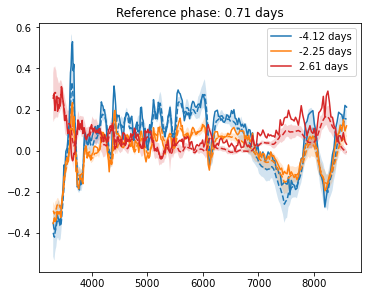

In [16]:
plt.figure()

idx = 0

target = a.targets[idx]
ref_spec = target.get_nearest_spectrum(0)
for spec_idx, spec in enumerate(target.get_spectra_in_range(-5, 5)):
    if spec == ref_spec:
        continue

    ref_mag = -2.5*np.log10(ref_spec.bin_by_velocity().flux)
    obs_mag = -2.5*np.log10(spec.bin_by_velocity().flux)
    model_diff = evaluate_phase_difference(spec.phase) - evaluate_phase_difference(ref_spec.phase)
    obs_diff = obs_mag - ref_mag
    uncertainty = np.sqrt(evaluate_phase_dispersion(spec.phase)**2 + evaluate_phase_dispersion(ref_spec.phase)**2)

    plt.plot(a.wave, obs_diff, c=f'C{spec_idx}', label=f'{spec.phase:.2f} days')
    plt.plot(a.wave, model_diff, c=f'C{spec_idx}', ls='--')
    plt.fill_between(a.wave, model_diff - uncertainty, model_diff + uncertainty, fc=f'C{spec_idx}', alpha=0.2)
    
plt.legend()

plt.title(f'Reference phase: {ref_spec.phase:.2f} days')

Text(0.5, 0, 'Pulls')

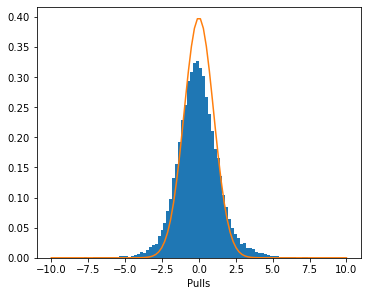

In [17]:
plt.figure()

all_pulls = []

for idx in range(len(a.targets)):
    target = a.targets[idx]
    ref_spec = target.get_nearest_spectrum(0)
    for spec_idx, spec in enumerate(target.get_spectra_in_range(-5, 5)):
        if spec == ref_spec:
            continue

        if np.abs(ref_spec.phase) > 1:
            continue

        if np.abs(spec.phase) < 3:
            continue
            
        bin_ref_spec = ref_spec.bin_by_velocity()
        bin_spec = spec.bin_by_velocity()

        ref_mag = -2.5*np.log10(bin_ref_spec.flux)
        obs_mag = -2.5*np.log10(bin_spec.flux)
        model_diff = evaluate_phase_difference(spec.phase) - evaluate_phase_difference(ref_spec.phase)
        obs_diff = obs_mag - ref_mag
        
        # Note: uncertainties are correlated so this isn't totally correct (and will underestimate them)
        # It is reasonably close though.
        uncertainty = np.sqrt(evaluate_phase_dispersion(spec.phase)**2 + evaluate_phase_dispersion(ref_spec.phase)**2 + bin_spec.fluxvar + bin_ref_spec.fluxvar)
        
        dd = obs_diff - model_diff
        zp = np.sum(1 / uncertainty**2 * dd) / np.sum(1 / uncertainty**2)
        dd = dd - zp
        
        pulls = (dd) / uncertainty
        
        # plt.plot(a.wave, (obs_diff - model_diff) / uncertainty, lw=1)
        all_pulls.append(pulls)

plt.hist(np.array(all_pulls).flat, 100, (-10, 10), density=True)
x = np.linspace(-10, 10, 100)
plt.plot(x, 1 / np.sqrt(2 * np.pi * 1.**2) * np.exp(-x**2 / 2 / 1.**2))
# plt.plot(x, 1 / np.sqrt(2 * np.pi * 1.2**2) * np.exp(-x**2 / 2 / 1.2**2))
plt.xlabel("Pulls")

# Reading between the lines plots

## Show spectra before and after

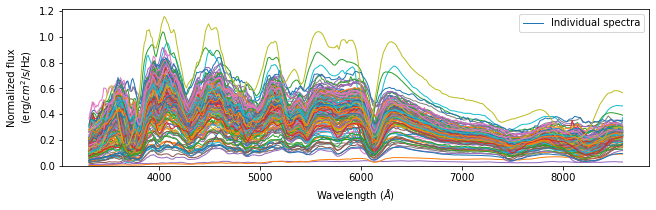

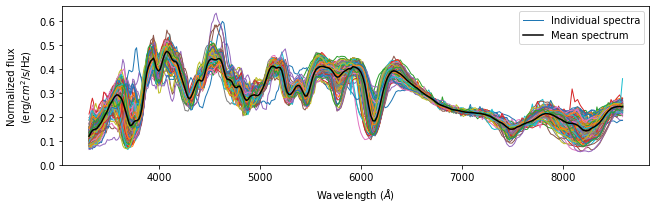

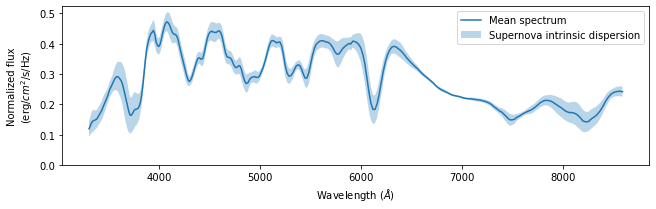

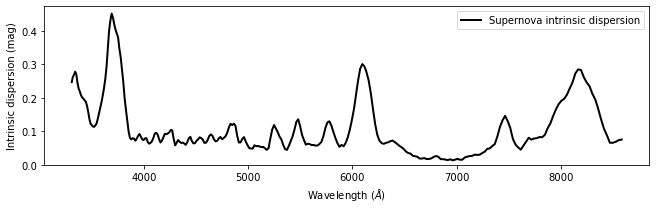

In [18]:
fig, ax = plt.subplots(figsize=a.settings['spectrum_plot_figsize'])
a.plot_flux(ax, a.maximum_flux[a.uncertainty_mask], lw=1, label='Individual spectra')
ax.legend()
a.savefig('spectra_at_maximum.pdf', fig)

fig, ax = plt.subplots(figsize=a.settings['spectrum_plot_figsize'])
a.plot_flux(ax, a.scale_flux[a.uncertainty_mask], lw=1., label='Individual spectra')
a.plot_flux(ax, a.mean_flux, c='k', label='Mean spectrum')
ax.legend()
a.savefig('scale_spectra.pdf', fig)

fig, ax = plt.subplots(figsize=a.settings['spectrum_plot_figsize'])
a.plot_flux(ax, a.mean_flux, a.mean_flux * a.rbtl_result['fractional_dispersion'], label='Mean spectrum', uncertainty_label='Supernova intrinsic dispersion')
ax.legend()
a.savefig('scale_spectra_model.pdf', fig)

fig, ax = plt.subplots(figsize=a.settings['spectrum_plot_figsize'])
intrinsic_dispersion = utils.frac_to_mag(a.rbtl_result['fractional_dispersion'])
ax.plot(a.wave, intrinsic_dispersion, c='k', lw=2, label='Supernova intrinsic dispersion')
ax.legend()
ax.set_xlabel(a.settings['spectrum_plot_xlabel'])
ax.set_ylabel('Intrinsic dispersion (mag)')
ax.set_ylim(0, None)
a.savefig('rbtl_intrinsic_dispersion.pdf', fig)

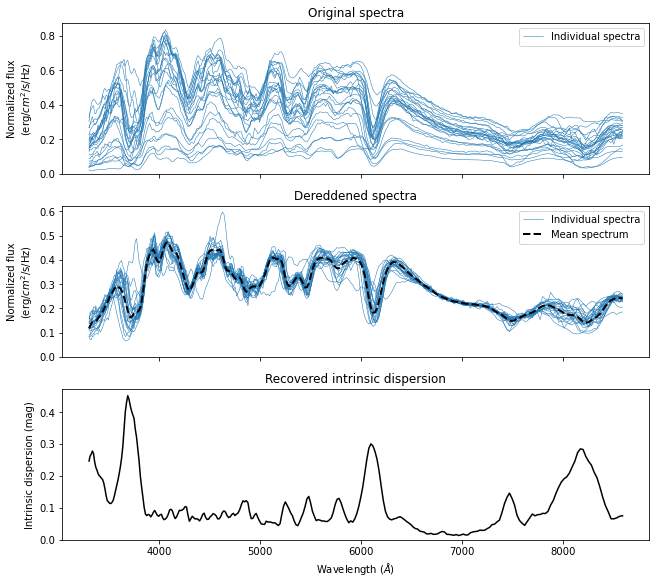

In [19]:
# Combined version

figsize = a.settings['spectrum_plot_figsize_triple']

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=figsize, sharex=True)

a.plot_flux(ax1, a.maximum_flux[::8], lw=0.5, label='Individual spectra', c='C0')
ax1.set_title('Original spectra')
ax1.set_xlabel(None)

a.plot_flux(ax2, a.scale_flux[a.uncertainty_mask][::8], lw=0.5, label='Individual spectra', c='C0')
a.plot_flux(ax2, a.mean_flux, c='k', lw=2, ls='--', label='Mean spectrum')
ax2.set_title('Dereddened spectra')
ax2.set_xlabel(None)

intrinsic_dispersion = utils.frac_to_mag(a.rbtl_result['fractional_dispersion'])
ax3.plot(a.wave, intrinsic_dispersion, c='k')
ax3.set_xlabel(a.settings['spectrum_plot_xlabel'])
ax3.set_ylabel('Intrinsic dispersion (mag)')
ax3.set_title('Recovered intrinsic dispersion')
ax3.set_ylim(0, None)

a.savefig('rbtl_spectra_combined.pdf')

# Manifold learning plots

## Plot the parameter space

Text(0.5, 0, '$\\xi_1$')

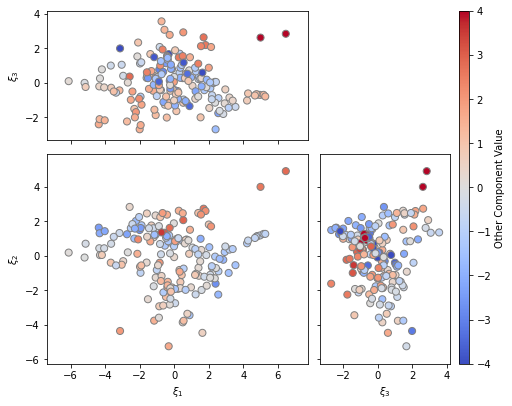

In [20]:
a.scatter_combined([a.embedding[:, 2], a.embedding[:, 1], a.embedding[:, 0]], a.uncertainty_mask, vmin=-4, vmax=4, label='Other Component Value')
a.savefig('embedding_components.pdf')
plt.gca().set_xlabel('$\\xi_1$')

## Slices through components

In [21]:
def plot_steps(ax, component, mask=True, num_steps=20, colorbar_aspect=50):
    mask = mask & a.uncertainty_mask

    use_embedding = a.embedding[mask, component]
    use_flux = a.scale_flux[mask]

    bin_edges = np.percentile(use_embedding, np.linspace(0, 100, num_steps + 1))
    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2.

    sm = plt.cm.ScalarMappable(cmap=a.settings['colormap'], norm=plt.Normalize(vmin=bin_centers[0], vmax=bin_centers[-1]))
    sm._A = []

    for step in range(num_steps):
        step_mask = (use_embedding >= bin_edges[step]) & (use_embedding < bin_edges[step+1])
        step_embedding = use_embedding[step_mask]

        mean_val = np.mean(step_embedding)
        step_flux = np.median(use_flux[step_mask], axis=0)

        # Make the extreme values of components get plotted on top if everything overlaps.
        zorder = np.abs(mean_val)

        a.plot_flux(ax, step_flux, c=sm.to_rgba(mean_val), zorder=zorder)

    fig.colorbar(sm, ax=ax, orientation='vertical', label='Component Value', pad=0, aspect=colorbar_aspect)

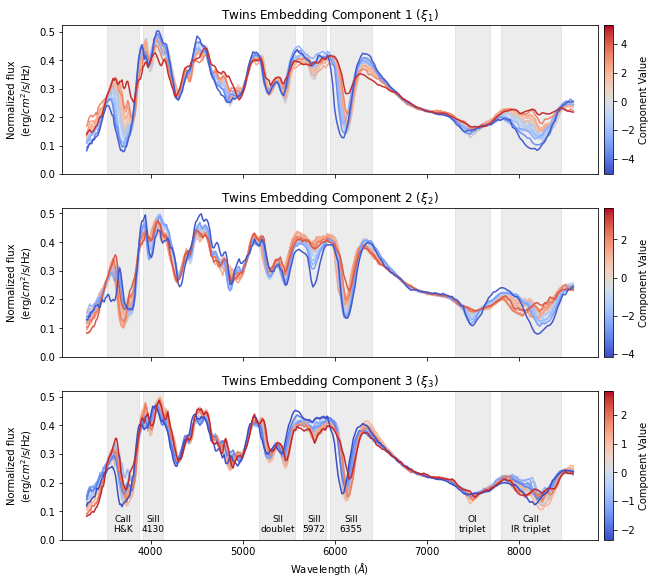

In [22]:
# All plots combined
# fig, axes = plt.subplots(3, 1, figsize=(a.settings['spectrum_plot_figsize'][0], a.settings['spectrum_plot_figsize'][1] * 3 - 1.5), sharex=True)
fig, axes = plt.subplots(3, 1, figsize=a.settings['spectrum_plot_figsize_triple'], sharex=True)

label_lines = {
    'SiII\n4130': (3920, 4130),
    'SiII\n5972': (5650, 5900),
    'SiII\n6355': (5950, 6400),
    'CaII\nH&K': (3530, 3870),
    'CaII\nIR triplet': (7800, 8450),
    'SII\ndoublet': (5180, 5570),
    'OI\ntriplet': (7300, 7680),
}

for component, ax in enumerate(axes):
    plot_steps(ax, component, colorbar_aspect=17)

    if component != 2:
        ax.set_xlabel(None)
        
    for line_label, (min_wave, max_wave) in label_lines.items():
        ax.axvspan(min_wave, max_wave, alpha=0.15, color='gray')
        mean_wave = (min_wave + max_wave) / 2.
        if component == 2:
            ax.text(mean_wave, 0.02, line_label, horizontalalignment='center', verticalalignment='bottom', fontsize=9.)

    ax.set_title('Twins Embedding Component %d ($\\xi_{%d}$)' % (component + 1, component + 1))
    # ax.set_ylabel('Normalized flux\n(erg/cm$^2$/s/Hz)')

a.savefig('component_steps_combined.pdf')

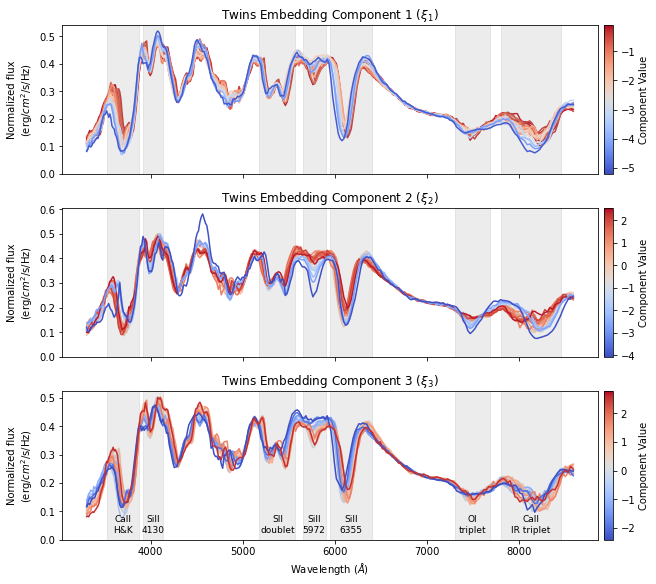

In [23]:
# All plots combined with a cut imposed for testing purposes.
# fig, axes = plt.subplots(3, 1, figsize=(a.settings['spectrum_plot_figsize'][0], a.settings['spectrum_plot_figsize'][1] * 3 - 1.5), sharex=True)
fig, axes = plt.subplots(3, 1, figsize=a.settings['spectrum_plot_figsize_triple'], sharex=True)

label_lines = {
    'SiII\n4130': (3920, 4130),
    'SiII\n5972': (5650, 5900),
    'SiII\n6355': (5950, 6400),
    'CaII\nH&K': (3530, 3870),
    'CaII\nIR triplet': (7800, 8450),
    'SII\ndoublet': (5180, 5570),
    'OI\ntriplet': (7300, 7680),
}

for component, ax in enumerate(axes):
    plot_steps(ax, component, (a.embedding[:, 0] < 0), colorbar_aspect=17)

    if component != 2:
        ax.set_xlabel(None)
        
    for line_label, (min_wave, max_wave) in label_lines.items():
        ax.axvspan(min_wave, max_wave, alpha=0.15, color='gray')
        mean_wave = (min_wave + max_wave) / 2.
        if component == 2:
            ax.text(mean_wave, 0.02, line_label, horizontalalignment='center', verticalalignment='bottom', fontsize=9.)

    ax.set_title('Twins Embedding Component %d ($\\xi_{%d}$)' % (component + 1, component + 1))
    # ax.set_ylabel('Normalized flux\n(erg/cm$^2$/s/Hz)')

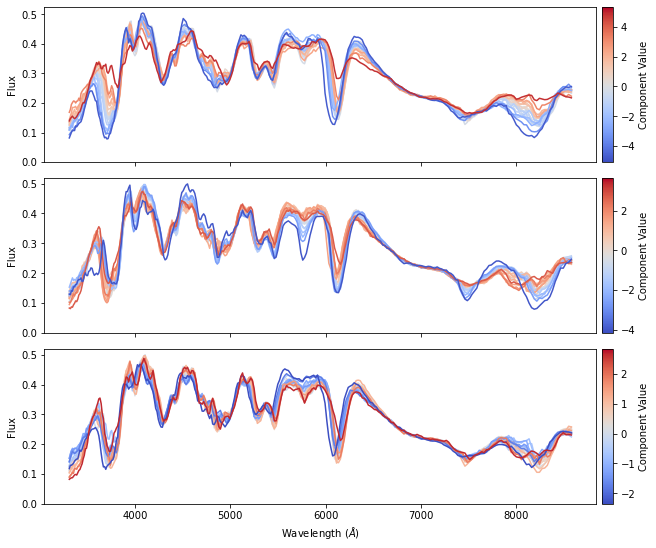

In [24]:
# Version for talks
fig, axes = plt.subplots(3, 1, figsize=(9, 7.5), sharex=True)

for component, ax in enumerate(axes):
    plot_steps(ax, component, colorbar_aspect=17)

    if component != 2:
        ax.set_xlabel(None)

    ax.set_ylabel('Flux')

a.savefig('component_steps_combined_talks.pdf')

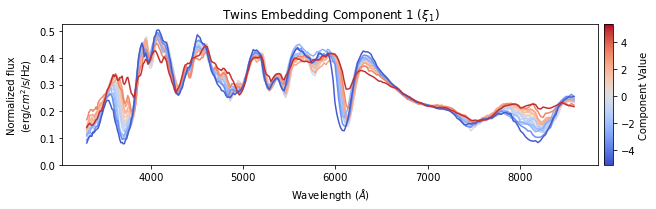

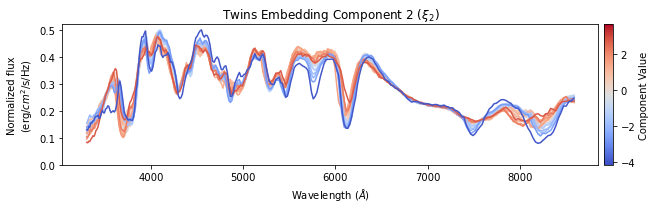

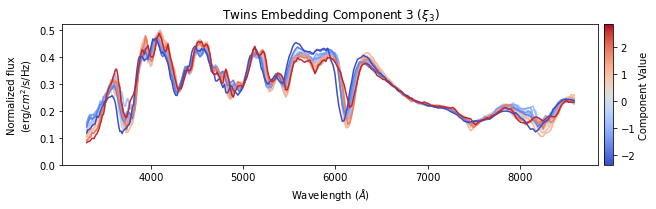

In [25]:
# Single plots
for component in range(a.settings['isomap_num_components']):
    fig, ax = plt.subplots(figsize=a.settings['spectrum_plot_figsize'])
    ax.set_title('Twins Embedding Component %d ($\\xi_{%d}$)' % (component + 1, component + 1))
    plot_steps(ax, component)

## Reconstruction uncertainty

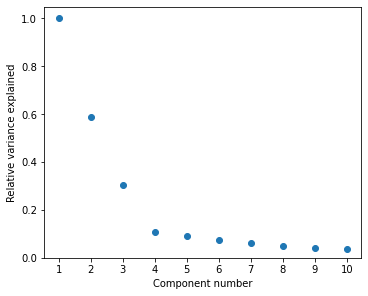

In [26]:
# Note: the total variance isn't defined for Isomap. The variances of the transfomed components
# do map onto the variance of real components though.

num_show = 10

# Do an initial embedding with as many components as possible to get the full variance.
embedding = a.generate_embedding(num_components=50)
variances = np.var(embedding[a.uncertainty_mask], axis=0)

ref_var = np.sum(variances[:10])

plot_ref = variances[0]

plt.figure()
plt.scatter(np.arange(num_show), variances[:num_show] / plot_ref, label='Contributed variance of each component')
plt.ylim(0, None)
plt.xlabel('Component number')
plt.ylabel('Relative variance explained')
plt.xticks(np.arange(num_show), np.arange(num_show) + 1)

a.savefig('isomap_component_variance.pdf')

## Twin reconstruction

In [27]:
from IPython.display import display
from scipy.spatial.distance import pdist
from scipy.stats import percentileofscore
import pandas as pd

def plot_twin_distances(embedding, twins_percentile=10, figsize=None):
    """Plot a histogram of where twins show up in the transformed
    embedding.
    """

    mask = a.uncertainty_mask

    spec_dists = pdist(a.fractional_differences[mask])
    embedding_dists = pdist(embedding[mask])

    splits = {
        "Best 10% of twinness": (0, 10),
        "10-20%": (10, 20),
        "20-50%": (20, 50),
        "Worst 50% of twinness": (50, 100),
    }

    # Set weight so that the histogram is 1 if we have every element in
    # that bin.
    weight = 100 / len(embedding_dists)

    all_percentiles = []
    all_weights = []

    all_spec_cuts = []
    all_embedding_cuts = []

    for label, (min_percentile, max_percentile) in splits.items():
        spec_cut = (spec_dists >= np.percentile(spec_dists, min_percentile)) & (
            spec_dists < np.percentile(spec_dists, max_percentile)
        )
        embedding_cut = (embedding_dists >= np.percentile(embedding_dists, min_percentile)) & (
            embedding_dists < np.percentile(embedding_dists, max_percentile)
        )
        percentiles = []
        for dist in embedding_dists[spec_cut]:
            percentiles.append(percentileofscore(embedding_dists, dist))
        percentiles = np.array(percentiles)
        weights = np.ones(len(percentiles)) * weight

        all_percentiles.append(percentiles)
        all_weights.append(weights)
        all_spec_cuts.append(spec_cut)
        all_embedding_cuts.append(embedding_cut)

    plt.figure(figsize=figsize)
    plt.hist(
        all_percentiles,
        100,
        (0, 100),
        weights=all_weights,
        histtype="barstacked",
        label=splits.keys(),
    )
    plt.xlabel("Recovered twinness percentile in the embedded space")
    plt.ylabel("Fraction in bin")
    plt.legend()

    plt.xlim(0, 100)
    plt.ylim(0, 1)

    for label, (min_percentile, max_percentile) in splits.items():
        plt.axvline(max_percentile, c="k", lw=2, ls="--")

    # Build leakage matrix.
    leakage_matrix = np.zeros((len(splits), len(splits)))
    for idx_1, label_1 in enumerate(splits.keys()):
        for idx_2, label_2 in enumerate(splits.keys()):
            spec_cut = all_spec_cuts[idx_1]
            embedding_cut = all_embedding_cuts[idx_2]
            leakage = np.sum(embedding_cut & spec_cut) / np.sum(spec_cut)
            leakage_matrix[idx_1, idx_2] = leakage

    # Print the leakage matrix using pandas
    df = pd.DataFrame(
        leakage_matrix,
        index=["From %s" % i for i in splits.keys()],
        columns=["To %s" % i for i in splits.keys()],
    )
    display(df)

    return leakage_matrix

,To Best 10% of twinness,To 10-20%,To 20-50%,To Worst 50% of twinness
From Best 10% of twinness,0.280914,0.276882,0.437500,0.004704
From 10-20%,0.173387,0.181452,0.547715,0.097446
From 20-50%,0.114945,0.109119,0.410710,0.365225
From Worst 50% of twinness,0.040199,0.042888,0.156494,0.760419


,To Best 10% of twinness,To 10-20%,To 20-50%,To Worst 50% of twinness
From Best 10% of twinness,0.579973,0.313172,0.106855,0.000000
From 10-20%,0.190860,0.305780,0.502688,0.000672
From 20-50%,0.057585,0.105086,0.600045,0.237284
From Worst 50% of twinness,0.011293,0.013176,0.118042,0.857489


,To Best 10% of twinness,To 10-20%,To 20-50%,To Worst 50% of twinness
From Best 10% of twinness,0.736559,0.235887,0.027554,0.000000
From 10-20%,0.196909,0.435484,0.367608,0.000000
From 20-50%,0.020614,0.105086,0.712973,0.161326
From Worst 50% of twinness,0.000941,0.002689,0.093170,0.903200


,To Best 10% of twinness,To 10-20%,To 20-50%,To Worst 50% of twinness
From Best 10% of twinness,0.747984,0.222446,0.029570,0.000000
From 10-20%,0.188844,0.459677,0.351478,0.000000
From 20-50%,0.019942,0.103294,0.716782,0.159982
From Worst 50% of twinness,0.000672,0.001613,0.093708,0.904006


,To Best 10% of twinness,To 10-20%,To 20-50%,To Worst 50% of twinness
From Best 10% of twinness,0.760753,0.208333,0.030914,0.000000
From 10-20%,0.190188,0.461694,0.348118,0.000000
From 20-50%,0.015460,0.107327,0.722384,0.154829
From Worst 50% of twinness,0.000538,0.001613,0.090750,0.906964


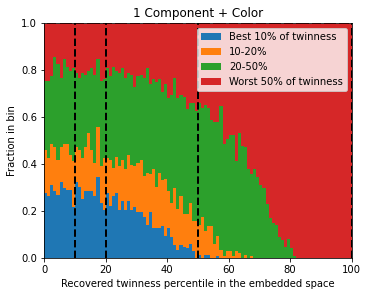

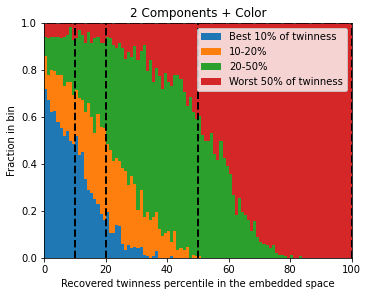

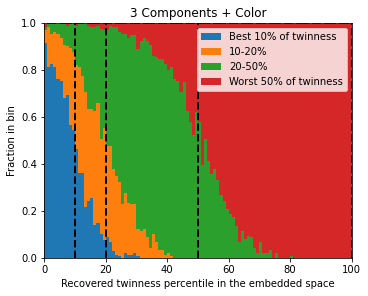

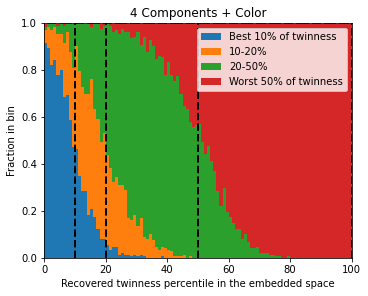

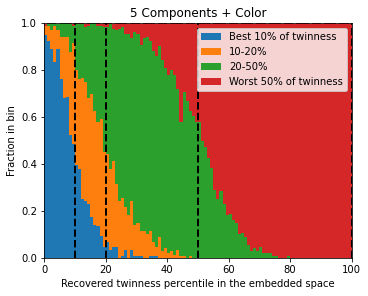

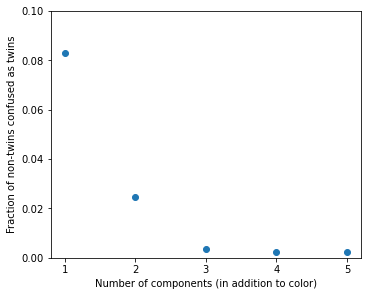

In [28]:
# Plot where twins and non-twins end up for different number of components.
# We also make a summary plot.
confused_fraction = []

plot_components = np.arange(1, 6)
for num_components in plot_components:
    embedding = a.generate_embedding(num_components=num_components)
    leakage_matrix = plot_twin_distances(embedding)
    if num_components == 1:
        title = '1 Component + Color'
    else:
        title = '%d Components + Color' % num_components
    plt.title(title)
    plt.xlabel('Recovered twinness percentile in the embedded space')
    a.savefig('twins_recovery_%d_components.pdf' % num_components)

    confused_fraction.append(leakage_matrix[3, 0] + leakage_matrix[3, 1])

plt.figure()
plt.scatter(np.arange(len(confused_fraction)) + 1, confused_fraction)
plt.xticks(plot_components, plot_components)
plt.ylim(0, 0.1)
plt.xlabel('Number of components (in addition to color)')
plt.ylabel('Fraction of non-twins confused as twins')
a.savefig('twins_confusion.pdf')

## Comparision to Branch classifications

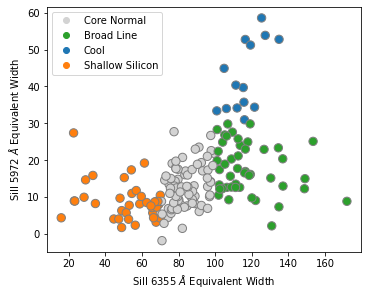

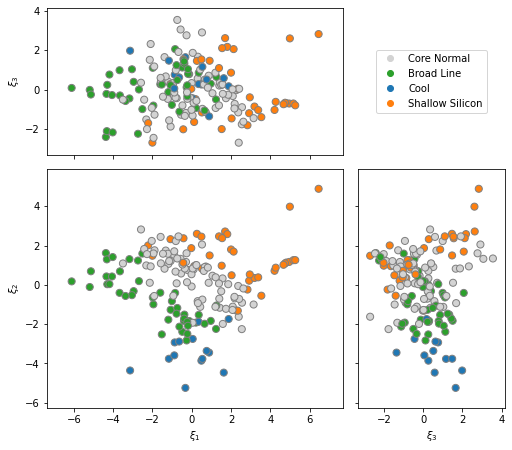

In [29]:
branch_colors = {
    # 'Broad Line': 'b',
    # 'Cool': 'r',
    # 'Core Normal': 'black',
    # 'Shallow Silicon': 'green',
    
    # 'Broad Line': 'C2',
    # 'Cool': 'C0',
    # 'Shallow Silicon': 'C3',
    # 'Core Normal': 'black',
    
    'Core Normal': 'lightgray',
    'Broad Line': 'C2',
    'Cool': 'C0',
    'Shallow Silicon': 'C1',
}

branch_classification = a.indicators['branch_classification']
mask = ~branch_classification.mask

from matplotlib.colors import ListedColormap
cmap = ListedColormap(branch_colors.values())
color_id_map = {j:i for i, j in enumerate(branch_colors)}
colors = np.array([color_id_map[i] for i in branch_classification[mask]])

fig, ax = plt.subplots()
scatter = ax.scatter(
    a.indicators['spectrum_EWSiII6355'][mask],
    a.indicators['spectrum_EWSiII5972'][mask],
    c=colors,
    cmap=cmap,
    s=a.settings['scatter_plot_marker_size'],
    edgecolors='gray'
)
ax.set_xlabel('SiII 6355 $\AA$ Equivalent Width')
ax.set_ylabel('SiII 5972 $\AA$ Equivalent Width')

ax.legend(handles=scatter.legend_elements()[0], labels=branch_colors.keys())

a.savefig('branch_classification.pdf', fig)

a.scatter_combined(branch_classification, mask, discrete_color_map=branch_colors, s=50, edgecolors='gray')
a.savefig('branch_labels.pdf')

## Variation of Core Normal SNe Ia

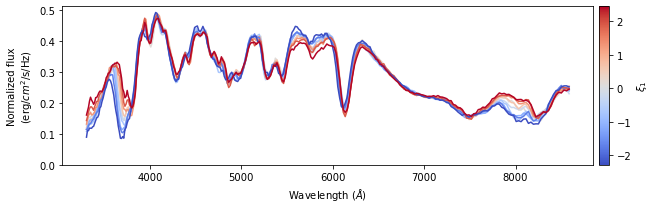

In [30]:
core_normal_cut = a.indicators['branch_classification'] == 'Core Normal'

component = 0

cut_flux = a.scale_flux[core_normal_cut]
cut_coord = a.embedding[core_normal_cut][:, component]

sort_flux = cut_flux[np.argsort(cut_coord)]
sort_coord = cut_coord[np.argsort(cut_coord)]

num_bins = 10

cmap = a.settings['colormap']
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=np.percentile(cut_coord, 100 / num_bins / 2), vmax=np.percentile(cut_coord, 100 * (1 - 1. / num_bins / 2))))
sm._A = []

def plot_spec(bin_idx, ax):
    min_idx = int(len(sort_coord) / num_bins * bin_idx)
    max_idx = int(len(sort_coord) / num_bins * (bin_idx + 1))
    bin_flux = sort_flux[min_idx:max_idx]
    
    f = np.median(bin_flux, axis=0)
    
    mean_val = np.mean(sort_coord[min_idx:max_idx])
    
    a.plot_flux(ax, f, c=sm.to_rgba(mean_val), zorder=np.abs(mean_val))
    # plt.plot(a.wave, f * spectrum_plot_scale, c=sm.to_rgba(mean_val), zorder=np.abs(mean_val))
    
fig, ax = plt.subplots(figsize=a.settings['spectrum_plot_figsize'])
for i in range(num_bins):
    plot_spec(i, ax)

fig.colorbar(sm, ax=ax, orientation='vertical', label='$\\xi_%d$' % (component + 1), pad=0, aspect=50)

a.savefig('core_normal_comparison.pdf', fig)

## Peculiar SNe Ia

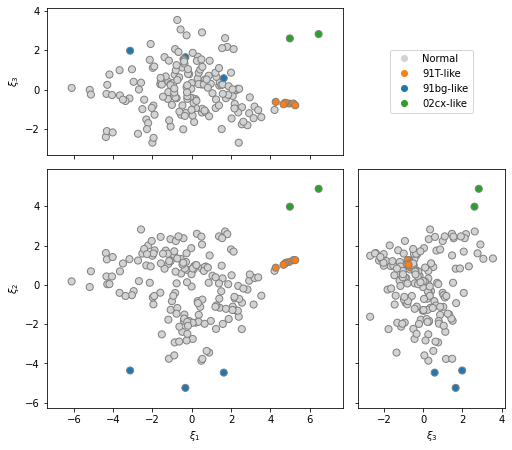

In [31]:
peculiar_colors = {
    'Normal': 'lightgray',
    '91T-like': 'C1',
    '91bg-like': 'C0',
    '02cx-like': 'C2',
}

a.scatter_combined(a.indicators['peculiar_type'], a.uncertainty_mask, discrete_color_map=peculiar_colors)
a.savefig('peculiar_locations.pdf')

In [32]:
# Count how many of each type, and write it out to a latex table
with a.latex_open('peculiar_counts.tex') as f:
    utils.latex_command(f, 'numpeculiarbg', '%d', np.sum(a.uncertainty_mask & (a.indicators['peculiar_type'] == '91bg-like')))
    utils.latex_command(f, 'numpeculiart', '%d', np.sum(a.uncertainty_mask & (a.indicators['peculiar_type'] == '91T-like')))
    utils.latex_command(f, 'numpeculiarcx', '%d', np.sum(a.uncertainty_mask & (a.indicators['peculiar_type'] == '02cx-like')))

\newcommand{\numpeculiarbg}{3}
\newcommand{\numpeculiart}{7}
\newcommand{\numpeculiarcx}{2}


## Sequences of SNe Ia

In [33]:
from scipy.spatial.distance import pdist, squareform
from scipy.stats import percentileofscore
from matplotlib import colors

In [34]:
dist_matrix = squareform(pdist(a.fractional_differences))
ref_dists = pdist(a.fractional_differences[a.uncertainty_mask])

def find_nearest(coords, mask=a.uncertainty_mask):
    dists = np.sum((a.embedding - np.asarray(coords))**2, axis=1)
    dists[~mask] = np.nan
    loc = np.nanargmin(dists)
    # print(loc, a.targets[loc], a.embedding[loc], a.indicators['peculiar_type'][loc])
    return loc
    
def find_sequence(start_coords, end_coords, mask=a.uncertainty_mask, num_steps=10):
    start_coords = np.asarray(start_coords)
    end_coords = np.asarray(end_coords)
    
    fig, ax = plt.subplots(figsize=a.settings['spectrum_plot_figsize'])

    # cmap = a.settings['colormap']
    # cmap = plt.cm.plasma
    # sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    # sm._A = []
    
    # Make a truncated colormap
    cmap = plt.cm.viridis
    # cmap = plt.cm.plasma
    cmap = colors.LinearSegmentedColormap.from_list('cut_cmap', cmap(np.linspace(0., 0.8, 100)))
    # cmap = a.settings['colormap']
    # cmap = plt.cm.plasma
    # cmap = plt.cm.jet

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0., vmax=1.))
    sm._A = []
    
    locs = []
    
    for frac in np.linspace(0, 1, num_steps):
        coords = start_coords + frac * (end_coords - start_coords)
        loc = find_nearest(coords, mask)
        
        if len(locs) == 0 or loc != locs[-1]:
            if frac == 0 or frac == 1:
                ls = '--'
            else:
                ls = '-'
            name = a.targets[loc].name
            iau_name = a.iau_name_map.get(name, name)
            a.plot_flux(ax, a.scale_flux[loc], c=sm.to_rgba(frac), label=iau_name, zorder=np.abs(frac - 0.5), ls=ls)
            print_str = f'{loc:3d} {name:20s} {a.embedding[loc, 0]:5.2f} {a.embedding[loc, 1]:5.2f} {a.embedding[loc, 2]:5.2f}   {a.indicators["peculiar_type"][loc]:20s}'
            if len(locs) > 0:
                print_str += f' {percentileofscore(ref_dists, dist_matrix[loc, locs[-1]]):.2f}'
            print(print_str)
            locs.append(loc)
        
    ax.legend(ncol=3)
    ax.set_ylim(0, 0.75)
    
    return locs

### Sequence from 91bg to 91T

 40 PTF11kjn             -0.32 -5.24  1.66   91bg-like           
193 SNNGC6343             0.54 -3.77  1.16   Normal               29.45
200 SNhunt281             0.76 -3.36  0.52   Normal               5.04
171 SNF20080810-001       1.88 -1.74  0.17   Normal               15.43
181 SNF20080918-002       2.08 -1.28  0.02   Normal               1.94
155 SNF20080516-022       2.41 -0.72  0.04   Normal               8.17
173 SNF20080822-005       2.96  0.53 -0.39   Normal               17.21
156 SNF20080522-000       4.27  0.88 -0.62   91T-like             5.86
\newcommand{\sequencebgname}{PTF11kjn}
\newcommand{\sequencebgcoord}{($-0.32, -5.24, 1.66$)}
\newcommand{\sequencebgtwin}{SN2013bs}
\newcommand{\sequencebgtwinpercentile}{29}
\newcommand{\sequencebgtcount}{8}
\newcommand{\sequencetname}{SNF20080522-000}
\newcommand{\sequencetcoord}{($4.27, 0.88, -0.62$)}
\newcommand{\sequencettwin}{SNF20080522-000}
\newcommand{\sequencettwinpercentile}{5}


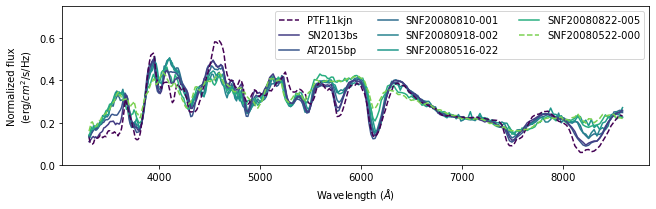

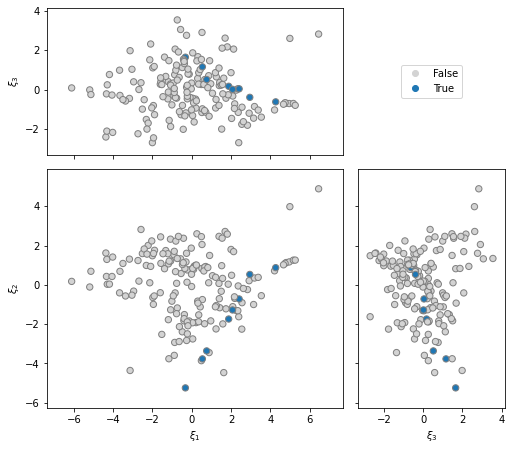

In [35]:
locs_91bg_91t = find_sequence([-0.3, -5.3, 2], [4., 2., -0.5], a.uncertainty_mask, 10)

a.savefig('sequence_91bg_91t.pdf')

label_colors = {
    False: 'lightgray',
    True: 'C0',
}
used_mask = np.array([i in locs_91bg_91t for i in range(len(a.targets))])
a.scatter_combined(used_mask, a.uncertainty_mask, discrete_color_map=label_colors, s=40)

def iau_name(name):
    return a.iau_name_map.get(name, name)

with a.latex_open('sequence_peculiars.tex') as f:
    utils.latex_command(f, 'sequencebgname', '%s', iau_name(a.targets[locs_91bg_91t[0]].name))
    utils.latex_command(f, 'sequencebgcoord', '($%.2f, %.2f, %.2f$)', tuple(a.embedding[locs_91bg_91t[0]]))
    utils.latex_command(f, 'sequencebgtwin', '%s', iau_name(a.targets[locs_91bg_91t[1]].name))
    utils.latex_command(f, 'sequencebgtwinpercentile', '%d', percentileofscore(ref_dists, dist_matrix[locs_91bg_91t[0], locs_91bg_91t[1]]))
    utils.latex_command(f, 'sequencebgtcount', '%d', len(locs_91bg_91t))
    utils.latex_command(f, 'sequencetname', '%s', iau_name(a.targets[locs_91bg_91t[-1]].name))
    utils.latex_command(f, 'sequencetcoord', '($%.2f, %.2f, %.2f$)', tuple(a.embedding[locs_91bg_91t[-1]]))
    utils.latex_command(f, 'sequencettwin', '%s', iau_name(a.targets[locs_91bg_91t[-1]].name))
    utils.latex_command(f, 'sequencettwinpercentile', '%d', percentileofscore(ref_dists, dist_matrix[locs_91bg_91t[-1], locs_91bg_91t[-2]]))

### Sequence from normal to 02cx

 62 SN2005cc              4.99  3.98  2.61   02cx-like           
101 SNF20060512-001       1.81  2.58  2.18   Normal               64.82
 20 PTF10hmv              0.91  1.50  1.47   Normal               8.36
179 SNF20080914-001       0.05  0.84  1.88   Normal               5.34
 29 PTF10ufj             -1.38  0.82  1.66   Normal               5.17
 36 PTF11bnx             -2.13  0.11  1.52   Normal               5.65
 55 PTF13anh             -3.04 -0.52  1.04   Normal               7.92
 38 PTF11cao             -3.67 -0.41  0.99   Normal               1.83
\newcommand{\sequencecxname}{SN2005cc}
\newcommand{\sequencecxcoord}{($4.99, 3.98, 2.61$)}
\newcommand{\sequencecxtwin}{SNF20060512-001}
\newcommand{\sequencecxtwinpercentile}{64}
\newcommand{\sequencecxend}{PTF11cao}


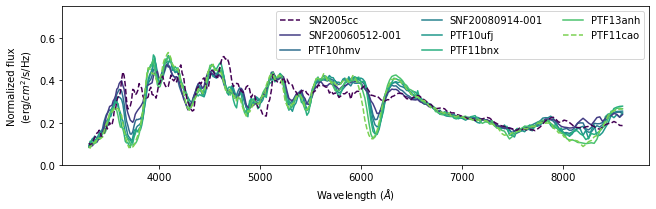

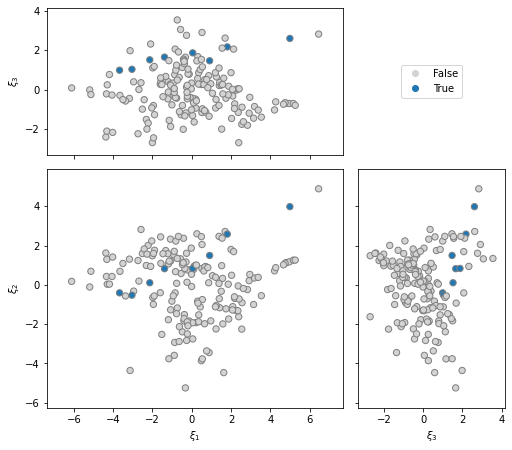

In [36]:
locs_02cx = find_sequence([5., 4., 2.], [-4., -1., 1.], a.uncertainty_mask, 10)

a.savefig('sequence_02cx.pdf')

label_colors = {
    False: 'lightgray',
    True: 'C0',
}
used_mask = np.array([i in locs_02cx for i in range(len(a.targets))])
a.scatter_combined(used_mask, a.uncertainty_mask, discrete_color_map=label_colors, s=40)

with a.latex_open('sequence_peculiars_cx.tex') as f:
    utils.latex_command(f, 'sequencecxname', '%s', a.targets[locs_02cx[0]].name)
    utils.latex_command(f, 'sequencecxcoord', '($%.2f, %.2f, %.2f$)', tuple(a.embedding[locs_02cx[0]]))
    utils.latex_command(f, 'sequencecxtwin', '%s', a.targets[locs_02cx[1]].name)
    utils.latex_command(f, 'sequencecxtwinpercentile', '%d', percentileofscore(ref_dists, dist_matrix[locs_02cx[0], locs_02cx[1]]))
    utils.latex_command(f, 'sequencecxend', '%s', a.targets[locs_02cx[-1]].name)

### Combined plot

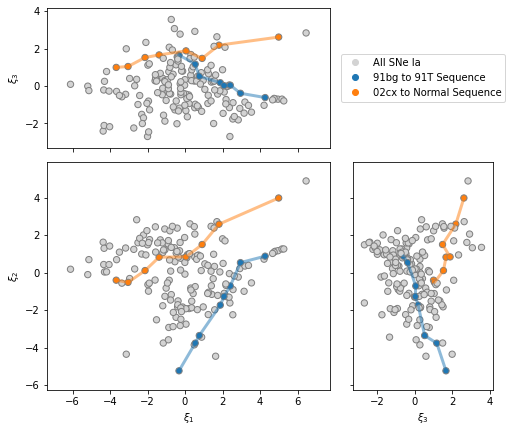

In [37]:
label_colors = {
    'All SNe Ia': 'lightgray',
    '91bg to 91T Sequence': 'C0',
    '02cx to Normal Sequence': 'C1',
}
labels = np.array(['All SNe Ia'] * len(a.targets), dtype='U30')
for loc in locs_02cx:
    labels[loc] = '02cx to Normal Sequence'
for loc in locs_91bg_91t:
    labels[loc] = '91bg to 91T Sequence'

ax12, ax13, ax32 = a.scatter_combined(labels, a.uncertainty_mask, discrete_color_map=label_colors, s=40)

def plot_sequence(locs, **kwargs):
    coord = a.embedding[locs]
    ax12.plot(coord[:, 0], coord[:, 1], **kwargs)
    ax13.plot(coord[:, 0], coord[:, 2], **kwargs)
    ax32.plot(coord[:, 2], coord[:, 1], **kwargs)
    
plot_sequence(locs_91bg_91t, label='Sequence in Figure 15', c='C0', alpha=0.5, lw=3)
plot_sequence(locs_02cx, label='Sequence in Figure 14', c='C1', alpha=0.5, lw=3)

a.savefig('sequence_locations.pdf')

## Color comparison

(<matplotlib.axes._subplots.AxesSubplot at 0x7f7ead1f1070>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7ead04f460>)

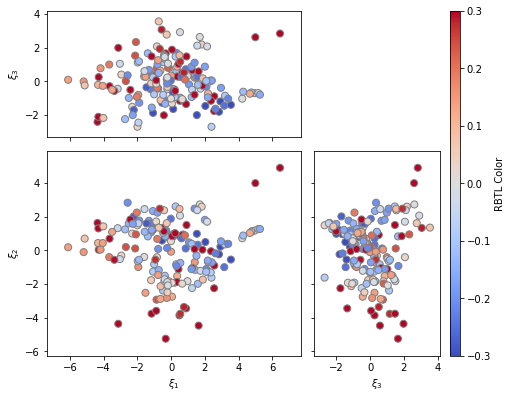

In [38]:
a.scatter_combined(a.rbtl_colors, a.uncertainty_mask, vmin=-0.3, vmax=0.3, label='RBTL Color')

## SALT2 x1 comparison

(<matplotlib.axes._subplots.AxesSubplot at 0x7f7eacf4f100>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7eacf28280>)

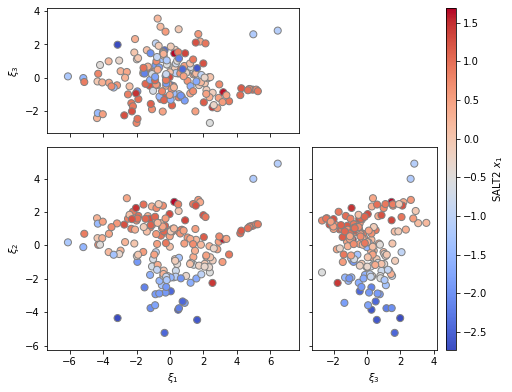

In [39]:
a.scatter_combined(a.salt_x1, a.uncertainty_mask, label='SALT2 $x_1$')

# Recovering other indicators of intrinsic diversity

## Do quadratic transformations for everything


In [40]:
isomap_indicators = [
    'isomap_c1',
    'isomap_c2',
    'isomap_c3',
]

sugar_indicators = [
    'sugar_q1',
    'sugar_q2',
    'sugar_q3',
]

snemo_indicators = [
    'snemo7_c1',
    'snemo7_c2',
    'snemo7_c3',
    'snemo7_c4',
    'snemo7_c5',
    'snemo7_c6',
]

salt_indicators = [
    'salt_x1',
]

target_indicators = {
    'spectrum_EWCaIIHK' : 'pEW CaII HK',
    'spectrum_EWSiII4000': 'pEW SiII 4000 $\AA$',
    'spectrum_EWSiII5972': 'pEW SiII 5972 $\AA$',
    'spectrum_EWSiII6355': 'pEW SiII 6355 $\AA$',
    'spectrum_vCaIIHK': 'Velocity Ca II HK',
    'spectrum_vSiII6355': 'Velocity Si II 6355 $\AA$',

    'salt_x1': 'SALT2 $x_1$ (B14)',
    
    # 'isomap_c1': 'Twins Embedding $\\xi_1$',
    # 'isomap_c2': 'Twins Embedding $\\xi_2$',
    # 'isomap_c3': 'Twins Embedding $\\xi_3$',

    # 'nordin_uNi_pre': 'uNi pre-peak\n(Nordin et al. 2018)',
    # 'nordin_uTi_pre': 'uTi pre-peak\n(Nordin et al. 2018)',
    # 'nordin_uSi_pre': 'uSi pre-peak\n(Nordin et al. 2018)',
    'nordin_uCa_pre': 'uCa pre-peak',
    'nordin_uCa_max': 'uCa near-peak',
    'nordin_uNi_max': 'uNi near-peak',
    'nordin_uSi_max': 'uSi near-peak',
    'nordin_uTi_max': 'uTi near-peak',
    # 'nordin_uNi_post': 'uNi post-peak\n(Nordin et al. 2018)',
    'nordin_uTi_post': 'uTi post-peak',
    # 'nordin_uSi_post': 'uSi post-peak\n(Nordin et al. 2018)',
    # 'nordin_uCa_post': 'uCa post-peak\n(Nordin et al. 2018)',

    # 'sugar_q1': 'SUGAR Component 1\n(Leget et al. 2019)',
    # 'sugar_q2': 'SUGAR Component 2',
    # 'sugar_q3': 'SUGAR Component 3',
    
    'sugar_q1': 'SUGAR $q_1$',
    'sugar_q2': 'SUGAR $q_2$',
    'sugar_q3': 'SUGAR $q_3$',
    
    # 'snemo7_c1': 'SNEMO7 Component 1\n(Saunders et al. 2018)',
    # 'snemo7_c2': 'SNEMO7 Component 2',
    # 'snemo7_c3': 'SNEMO7 Component 3',
    # 'snemo7_c4': 'SNEMO7 Component 4',
    # 'snemo7_c5': 'SNEMO7 Component 5',
    # 'snemo7_c6': 'SNEMO7 Component 6',

    'snemo7_c1': 'SNEMO7 $c_1$',
    'snemo7_c2': 'SNEMO7 $c_2$',
    'snemo7_c3': 'SNEMO7 $c_3$',
    'snemo7_c4': 'SNEMO7 $c_4$',
    'snemo7_c5': 'SNEMO7 $c_5$',
    'snemo7_c6': 'SNEMO7 $c_6$',
    
    # 'snemo15_c1': 'SNEMO15 Component 1\n(Saunders et al. 2018)',
    # 'snemo15_c2': 'SNEMO15 Component 2\n(Saunders et al. 2018)',
    # 'snemo15_c3': 'SNEMO15 Component 3\n(Saunders et al. 2018)',
    # 'snemo15_c4': 'SNEMO15 Component 4\n(Saunders et al. 2018)',
    # 'snemo15_c5': 'SNEMO15 Component 5\n(Saunders et al. 2018)',
    # 'snemo15_c6': 'SNEMO15 Component 6\n(Saunders et al. 2018)',
    # 'snemo15_c7': 'SNEMO15 Component 7\n(Saunders et al. 2018)',
    # 'snemo15_c8': 'SNEMO15 Component 8\n(Saunders et al. 2018)',
    # 'snemo15_c9': 'SNEMO15 Component 9\n(Saunders et al. 2018)',
    # 'snemo15_c10': 'SNEMO15 Component 10\n(Saunders et al. 2018)',
    # 'snemo15_c11': 'SNEMO15 Component 11\n(Saunders et al. 2018)',
    # 'snemo15_c12': 'SNEMO15 Component 12\n(Saunders et al. 2018)',
    # 'snemo15_c13': 'SNEMO15 Component 13\n(Saunders et al. 2018)',
    # 'snemo15_c14': 'SNEMO15 Component 14\n(Saunders et al. 2018)',
}

In [41]:
from ipywidgets import interact

reference_indicators = {
    'twins_embedding': isomap_indicators,
    'sugar': sugar_indicators,
    'snemo': snemo_indicators,
    'salt': salt_indicators,
}

def plot_indicator(indicator, reference_indicators, quadratic=True):
    quadratic_reference_indicators = []
    linear_reference_indicators = []

    if quadratic:
        quadratic_reference_indicators.extend(reference_indicators)
    else:
        linear_reference_indicators.extend(reference_indicators)

    explained_variance, coefficients, transformation, mask \
        = a.find_best_transformation(
        indicator,
        quadratic_reference_indicators,
        linear_reference_indicators
    )
    
    print(np.std(a.indicators[indicator][mask]), np.std(a.indicators[indicator][mask] - transformation[mask]))

    plt.figure()
    plt.scatter(transformation[mask], a.indicators[indicator][mask])

    plt.xlabel('Transformation of the Isomap latent space')
    plt.ylabel(indicator)
    plt.title(f'Explained variance: {explained_variance:.2f}')

interact(plot_indicator, indicator=a.indicators.keys()[1:], reference_indicators=reference_indicators)

interactive(children=(Dropdown(description='indicator', options=('isomap_c1', 'isomap_c2', 'isomap_c3', 'salt_…

<function __main__.plot_indicator(indicator, reference_indicators, quadratic=True)>

In [42]:
# Compare how indicators are recovered with different latent spaces
mask = (~a.indicators['sugar_q1'].mask) & (~a.indicators['isomap_c1'].mask)

last_kind = ''
for target_indicator in target_indicators:
    kind = target_indicator.split('_')[0]
    if kind != last_kind:
        print("")
        last_kind = kind
    isomap_trans = a.find_best_transformation(target_indicator, isomap_indicators, mask=mask)
    isomap_trans_linear = a.find_best_transformation(target_indicator, [], isomap_indicators, mask=mask)
    sugar_trans = a.find_best_transformation(target_indicator, sugar_indicators, mask=mask)
    # salt_trans = a.find_best_transformation(target_indicator, salt_indicators, mask=mask)
    # snemo_trans = a.find_best_transformation(target_indicator, snemo_indicators, mask=mask)
    # isomap_c_trans = a.find_best_transformation(target_indicator, isomap_indicators, [a.rbtl_colors], mask=mask)
    # sugar_c_trans = a.find_best_transformation(target_indicator, sugar_indicators, [a.rbtl_colors], mask=mask)
    
    # print(f'{target_indicator:20s} {isomap_trans[0]:.3f} {sugar_trans[0]:.3f}')
    # print(f'{target_indicator:20s} {isomap_trans[0]:.3f} {isomap_trans_linear[0]:.3f} {sugar_trans[0]:.3f}')
    print(f'{target_indicator:20s} {isomap_trans[0]:.3f} {sugar_trans[0]:.3f}')


spectrum_EWCaIIHK    0.893 0.724
spectrum_EWSiII4000  0.871 0.885
spectrum_EWSiII5972  0.651 0.760
spectrum_EWSiII6355  0.912 0.828
spectrum_vCaIIHK     0.688 0.570
spectrum_vSiII6355   0.819 0.736

salt_x1              0.771 0.943

nordin_uCa_pre       0.845 0.660
nordin_uCa_max       0.795 0.571
nordin_uNi_max       0.684 0.460
nordin_uSi_max       0.928 0.836
nordin_uTi_max       0.713 0.730
nordin_uTi_post      0.787 0.779

sugar_q1             0.814 1.000
sugar_q2             0.885 1.000
sugar_q3             0.578 1.000

snemo7_c1            0.924 0.878
snemo7_c2            0.807 0.948
snemo7_c3            0.846 0.894
snemo7_c4            0.609 0.791
snemo7_c5            0.695 0.788
snemo7_c6            0.712 0.706


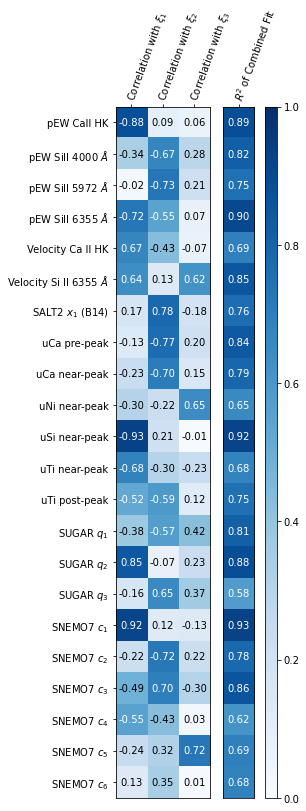

In [43]:
from matplotlib import colors

ref_indicators = isomap_indicators

labels = []
all_correlations = []
all_coefficients = []
all_explained_variances = []
all_transformed_correlations = []

for target_indicator, target_label in target_indicators.items():
    if target_indicator in ref_indicators:
        continue
    explained_variance, coefficients, transformation, mask \
        = a.find_best_transformation(target_indicator, ref_indicators)

    indicator_values = a.indicators[target_indicator]

    labels.append(target_label)
    all_coefficients.append(coefficients)
    all_explained_variances.append(explained_variance)

    # correlations = [np.corrcoef(transformation[mask], a.embedding[mask, i])[0, 1] for i in range(a.embedding.shape[1])]
    correlations = [np.corrcoef(indicator_values[mask], a.embedding[mask, i])[0, 1] for i in range(a.embedding.shape[1])]
    all_correlations.append(correlations)
    
    transformed_correlations = np.corrcoef(indicator_values[mask], transformation[mask])[0, 1]
    all_transformed_correlations.append(transformed_correlations)

all_coefficients = np.array(all_coefficients)
all_correlations = np.array(all_correlations)
all_explained_variances = np.array(all_explained_variances)
all_transformed_correlations = np.array(all_transformed_correlations)

# norm = 1 / np.sqrt(np.sum(all_coefficients[:, 1:4]**2, axis=1))[:, None]
# norm_coefficients = norm * all_coefficients[:, 1:4]

fig = plt.figure(figsize=(4.9, 12.), constrained_layout=False)

# left bottom width height
ax1 = fig.add_axes([0.26, 0.01, 0.45, 0.8])
ax2 = fig.add_axes([0.52, 0.01, 0.3, 0.8], sharey=ax1)
# cax = fig.add_subplot(gs[0, 2])

# fig, axes = plt.subplots(1, 3, sharey=True, figsize=(4.0, 10), gridspec_kw={'width_ratios': (3, 1, 1)}, constrained_layout=False)
# fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.01, hspace=0.01, wspace=0.01)

# cmap1 = a.settings['colormap']
# cmap1 = a.settings['colormap']
# sm1 = plt.cm.ScalarMappable(cmap=cmap1, norm=plt.Normalize(vmin=-1, vmax=1))
# sm1._A = []

# Make a truncated colormap
# cmap2 = plt.cm.Purples
cmap2 = plt.cm.Blues
# cmap2 = colors.LinearSegmentedColormap.from_list('unexp_var_cmap', cmap2(np.linspace(0., 0.8, 100)))
sm2 = plt.cm.ScalarMappable(cmap=cmap2, norm=plt.Normalize(vmin=0., vmax=1.))
sm2._A = []

def do_plot(ax, ax_data, sm, xlabels, ylabels=None, threshold=0.5):
    ax_data = np.atleast_2d(ax_data)
    im = ax.imshow(sm.to_rgba(np.abs(ax_data)), interpolation='nearest', vmin=-1, vmax=1)
    ax.set(
        xticks=np.arange(ax_data.shape[1]),
        yticks=np.arange(ax_data.shape[0]),
        xticklabels=xlabels,
    )

    if ylabels is not None:
        ax.set_yticklabels(ylabels)
    else:
        ax.tick_params(axis='y', which='both', left=False, right=False)

    # Ticks on top
    ax.get_xaxis().set_ticks_position('top')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=70, ha="left", va='center',
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    for i in range(ax_data.shape[0]):
        for j in range(ax_data.shape[1]):
            ax.text(j, i, format(ax_data[i, j], fmt),
                    ha="center", va="center",
                    color="white" if np.sign(threshold) * np.abs(ax_data[i, j]) > threshold else "black")

# do_plot(ax1, norm_coefficients, sm1, ['Component 1 Amplitude', 'Component 2 Amplitude', 'Component 3 Amplitude'], labels)
do_plot(ax1, all_correlations, sm2, ['Correlation with $\\xi_1$', 'Correlation with $\\xi_2$', 'Correlation with $\\xi_3$'], labels)
# do_plot(ax2, all_explained_variances[:, None], sm2, ['Fraction of Variance\nExplained'], threshold=0.5)
# do_plot(ax2, np.array([all_explained_variances, all_transformed_correlations]).T, sm2, ['Fraction of Variance\nExplained', 'Transformed Correlation'])
do_plot(ax2, np.array([all_explained_variances]).T, sm2, ['$R^2$ of Combined Fit'])

ax2.tick_params(labelleft=False)

# cbar1 = fig.colorbar(sm1, ax=ax1, orientation='vertical', aspect=60, pad=0.05, ticks=[-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
# cbar1.ax.set_yticklabels(['-1', '', '', '', '', '0', '', '', '', '', '1'])
# cbar2 = fig.colorbar(sm2, ax=ax2, orientation='vertical', aspect=60, pad=0.05, ticks=[0, 0.25, 0.5, 0.75, 1])
# cbar2 = fig.colorbar(sm2, ax=ax2, orientation='vertical', aspect=60, pad=0.05, ticks=[0.5, 0.6, 0.7, 0.8, 0.9, 1])
cbar2 = fig.colorbar(sm2, ax=ax2, orientation='vertical', aspect=60, pad=0.1, ticks=[0., 0.2, 0.4, 0.6, 0.8, 1])
# cbar2.ax.set_yticklabels(['0', '', '0.5', '', '1'])

a.savefig('indicators_recovery.pdf', bbox_inches='tight', pad_inches=0)

## Figure out what fraction of explained variance we would expect

In [44]:
def simulate_explained(target_indicator, reference_indicators, N=100):
    all_explained_variances = []
    all_correlations = []

    vals = a.indicators[target_indicator]

    for i in tqdm(range(N), leave=False):
        explained_variance, coefficients, best_transformation, mask = \
            a.find_best_transformation(target_indicator, reference_indicators, shuffle=True)
        all_explained_variances.append(explained_variance)
        all_correlations.append(np.corrcoef(vals[mask], best_transformation[mask])[0, 1])

    mean_explained = np.mean(all_explained_variances)
    std_explained = np.std(all_explained_variances)
    mean_corr = np.mean(all_correlations)
    std_corr = np.std(all_correlations)

    return mean_explained, std_explained, mean_corr, std_corr

In [45]:
reference_indicators = isomap_indicators
for target_indicator in tqdm(target_indicators):
    mean_explained, std_explained, mean_corr, std_corr = simulate_explained(target_indicator, reference_indicators)
    print(f'{target_indicator:20s}: {mean_explained:.3f} ± {std_explained:.3f}      {mean_corr:.3f} ± {std_corr:.3f}')

spectrum_EWCaIIHK   : 0.051 ± 0.022      0.220 ± 0.047


spectrum_EWSiII4000 : 0.055 ± 0.026      0.227 ± 0.057


spectrum_EWSiII5972 : 0.054 ± 0.027      0.227 ± 0.056


spectrum_EWSiII6355 : 0.053 ± 0.024      0.225 ± 0.051


spectrum_vCaIIHK    : 0.052 ± 0.027      0.222 ± 0.055


spectrum_vSiII6355  : 0.051 ± 0.024      0.220 ± 0.051


salt_x1             : 0.058 ± 0.028      0.235 ± 0.056


nordin_uCa_pre      : 0.166 ± 0.073      0.398 ± 0.090


nordin_uCa_max      : 0.139 ± 0.058      0.365 ± 0.078


nordin_uNi_max      : 0.141 ± 0.059      0.367 ± 0.077


nordin_uSi_max      : 0.131 ± 0.046      0.356 ± 0.065


nordin_uTi_max      : 0.132 ± 0.049      0.358 ± 0.068


nordin_uTi_post     : 0.159 ± 0.067      0.390 ± 0.081


sugar_q1            : 0.064 ± 0.029      0.247 ± 0.057


sugar_q2            : 0.063 ± 0.026      0.244 ± 0.053


sugar_q3            : 0.063 ± 0.028      0.246 ± 0.056


snemo7_c1           : 0.056 ± 0.026      0.230 ± 0.055


snemo7_c2           : 0.062 ± 0.033      0.240 ± 0.065


snemo7_c3           : 0.057 ± 0.024      0.232 ± 0.050


snemo7_c4           : 0.058 ± 0.029      0.235 ± 0.057


snemo7_c5           : 0.064 ± 0.029      0.246 ± 0.057


snemo7_c6           : 0.065 ± 0.028      0.248 ± 0.055



In [46]:
with a.latex_open('explained_variance_simulation.tex') as f:
    reference_indicators = isomap_indicators
    N = 1000
    
    target_indicator = 'salt_x1'
    mean_explained, std_explained, mean_corr, std_corr = simulate_explained(target_indicator, reference_indicators, N=N)
    print(f'{target_indicator} {mean_explained:.3f} ± {std_explained:.3f}')
    utils.latex_command(f, 'explainedvariancexonemean', '%.3f', mean_explained)
    utils.latex_command(f, 'explainedvariancexonestd', '%.3f', std_explained)

    target_indicator = 'nordin_uNi_max'
    mean_explained, std_explained, mean_corr, std_corr = simulate_explained(target_indicator, reference_indicators, N=N)
    print(f'{target_indicator} {mean_explained:.3f} ± {std_explained:.3f}')
    utils.latex_command(f, 'explainedvarianceunimean', '%.3f', mean_explained)
    utils.latex_command(f, 'explainedvarianceunistd', '%.3f', std_explained)

salt_x1 0.059 ± 0.027
\newcommand{\explainedvariancexonemean}{0.059}
\newcommand{\explainedvariancexonestd}{0.027}


nordin_uNi_max 0.133 ± 0.056
\newcommand{\explainedvarianceunimean}{0.133}
\newcommand{\explainedvarianceunistd}{0.056}


# Attrition

In [47]:
with a.latex_open('attrition_variables.tex') as f:
    utils.latex_command(f, 'numdatasetsne', '%d', a.attrition_enough_spectra)
    utils.latex_command(f, 'numdatasetspectra', '%d', a.attrition_total_spectra)
    utils.latex_print(f, "")
    utils.latex_command(f, 'nummanifoldsne', '%d', len(a.targets))
    utils.latex_command(f, 'nummanifoldspectra', '%d', len(a.spectra))
    utils.latex_command(f, 'numinterpsne', '%d', np.sum(a.uncertainty_mask))

\newcommand{\numdatasetsne}{280}
\newcommand{\numdatasetspectra}{3908}

\newcommand{\nummanifoldsne}{203}
\newcommand{\nummanifoldspectra}{598}
\newcommand{\numinterpsne}{173}


In [48]:
with a.latex_open('attrition_table.tex') as f:
    utils.latex_print(f, "\\textbf{General selection requirements} & \\\\")
    utils.latex_print(f, "Initial sample (SNe Ia with at least 5 SNfactory spectra) & %d \\\\" % a.attrition_enough_spectra)
    utils.latex_print(f, "SALT2 date of maximum light uncertainty < 1 day           & %d \\\\" % a.attrition_salt_daymax)
    utils.latex_print(f, "At least one spectrum within 5 days of maximum light      & %d \\\\" % a.attrition_range)
    utils.latex_print(f, "At least one spectrum with S/N 3300-3800~\AA\ > 100       & %d \\\\" % a.attrition_usable)
    utils.latex_print(f, "\hline")
    utils.latex_print(f, "\\textbf{Manifold learning selection requirements} & \\\\")
    utils.latex_print(f, r"\textbf{(Section~\ref{sec:isomap_sample})} & \\")
    utils.latex_print(f, "Spectrum at max. uncertainty < 10\\%% of intrinsic power        & %d \\\\" % np.sum(a.uncertainty_mask))

\textbf{General selection requirements} & \\
Initial sample (SNe Ia with at least 5 SNfactory spectra) & 280 \\
SALT2 date of maximum light uncertainty < 1 day           & 272 \\
At least one spectrum within 5 days of maximum light      & 250 \\
At least one spectrum with S/N 3300-3800~\AA\ > 100       & 203 \\
\hline
\textbf{Manifold learning selection requirements} & \\
\textbf{(Section~\ref{sec:isomap_sample})} & \\
Spectrum at max. uncertainty < 10\% of intrinsic power        & 173 \\


# Dump of the embedding

In [49]:
rbtl_mag_errs, rbtl_color_errs = a._calculate_rbtl_uncertainties()
pv_errs = a.calculate_peculiar_velocity_uncertainties(a.redshifts)
mag_errs = np.sqrt(rbtl_mag_errs**2 + pv_errs**2)

data_table = Table({
    'name': [a.iau_name_map.get(i.name, i.name).replace('_', '\_') for i in a.targets],
    # 'SALT2 $x_1$': ['%.2f $\pm$ %.2f' % (i, j) for i, j in zip(a.salt_x1, a.salt_fits['x1_err'])],
    # 'SALT2 $color$': ['%.2f $\pm$ %.2f' % (i, j) for i, j in zip(a.salt_colors, a.salt_fits['c_err'])],
    'SALT2 $x_1$': ['%.3f' % i for i in a.salt_x1],
    'SALT2 $x_1$ uncertainty': ['%.3f' % i for i in a.salt_fits['x1_err']],
    'SALT2 $c$': ['%.3f' % i for i in a.salt_colors],
    'SALT2 $c$ uncertainty': ['%.3f' % i for i in a.salt_fits['c_err']],
    'RBTL $A_V$': ['%.3f' % i for i in a.rbtl_colors],
    'RBTL $A_V$ uncertainty': ['%.3f' % i for i in rbtl_color_errs],
    'RBTL $\Delta M$': ['%.3f' % i for i in a.rbtl_mags],
    'RBTL $\Delta M$ uncertainty': ['%.3f' % i for i in mag_errs],
    'Twins Embedding Coordinate 1': ['%.3f' % i for i in a.embedding[:, 0]],
    'Twins Embedding Coordinate 2': ['%.3f' % i for i in a.embedding[:, 1]],
    'Twins Embedding Coordinate 3': ['%.3f' % i for i in a.embedding[:, 2]],
})

def dump_data(f, start=None, end=None):
    for row in data_table[start:end]:
        print(' & '.join(row) + ' \\\\', file=f)

with a.latex_open('twins_manifold_coordinates.tex') as f:
    dump_data(f)

with a.latex_open('twins_manifold_coordinates_short.tex') as f:
    dump_data(f, 95, 105)

# Dump of the spectra

In [50]:
import os

outdir = './data_release/'

os.makedirs(outdir, exist_ok=True)

readme_txt = """Data release for the Twins Embedding analysis (Boone et al. 2020a, 2020b)

Contact: Kyle Boone <kyboone@uw.edu>

These files contain the spectra of each of the supernovae used in the Twins Embedding analysis.
The spectra are provided in the restframe after they have been shifted to maximum light
and dereddened using the Reading Between the Lines (RBTL) algorithm.

Each file contains the data for a single supernova, with three columns of wavelength,
flux, and flux uncertainty.
"""

with open(f'{outdir}/README.txt', 'w') as f:
    print(readme_txt, file=f)

for idx, target in enumerate(a.targets):
    target_flux = a.scale_flux[idx]
    target_fluxerr = a.scale_fluxerr[idx]
    with open(f'{outdir}/{target}.dat', 'w') as f:
        print(' Wavelength            Flux     Uncertainty', file=f)
        for wave, flux, fluxerr in zip(a.wave, target_flux, target_fluxerr):
            print(f'{wave:11f} {flux:15e} {fluxerr:15e}', file=f)

# Dump of the model parameters

In [51]:
def to_str(fmt, x):
    return [fmt % i for i in x]
    

data_table = Table({
    'Wavelength': to_str('%d', a.wave),
    'Time evolution c1': to_str('%.3f', a.differential_evolution_result['phase_slope']),
    'Time evolution c2': to_str('%.5f', a.differential_evolution_result['phase_quadratic']),
    'Model uncertainties -5.0 days': to_str('%.3f', evaluate_phase_dispersion(-5)),
    'Model uncertainties -2.5 days': to_str('%.3f', evaluate_phase_dispersion(-2.5)),
    'Model uncertainties +2.5 days': to_str('%.3f', evaluate_phase_dispersion(2.5)),
    'Model uncertainties +5.0 days': to_str('%.3f', evaluate_phase_dispersion(5.)),
    'RBTL intrinsic dispersion': to_str('%.3f', utils.frac_to_mag(a.rbtl_result['fractional_dispersion'])),
})

def dump_data(f, count=None):
    if count is not None:
        offset = len(data_table) // count
        ref = offset // 2
    else:
        offset = None
        ref = None
        
    for row in data_table[ref::offset]:
        print(' & '.join(row) + ' \\\\', file=f)

with a.latex_open('differential_time_evolution_parameters.tex') as f:
    dump_data(f)

with a.latex_open('differential_time_evolution_parameters_short.tex') as f:
    dump_data(f, 10)

# Tests of dust variation

Mean offset F99:  -0.1396
Sigma offset F99: 0.0161
Mean offset CCM:  -0.1398
Sigma offset CCM: 0.0121


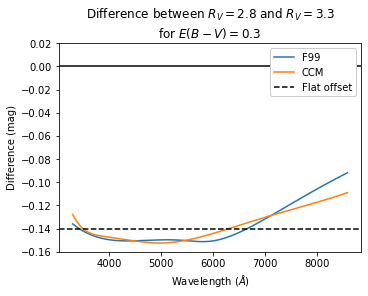

In [52]:
import extinction
plt.figure()
ref_extinction = extinction.fitzpatrick99(a.wave, 0.3 * 2.8, 2.8)
new_extinction = extinction.fitzpatrick99(a.wave, 0.3 * 3.3, 3.3)
plt.plot(a.wave, ref_extinction - new_extinction, label='F99')

print("Mean offset F99:  %.4f" % np.mean(ref_extinction - new_extinction))
print("Sigma offset F99: %.4f" % np.std(ref_extinction - new_extinction))

# plt.figure()
ref_extinction = extinction.ccm89(a.wave, 0.3 * 2.8, 2.8)
new_extinction = extinction.ccm89(a.wave, 0.3 * 3.3, 3.3)
plt.plot(a.wave, ref_extinction - new_extinction, label='CCM')

print("Mean offset CCM:  %.4f" % np.mean(ref_extinction - new_extinction))
print("Sigma offset CCM: %.4f" % np.std(ref_extinction - new_extinction))

plt.xlabel('Wavelength ($\AA$)')
plt.ylabel('Difference (mag)')
plt.title('Difference between $R_V=2.8$ and $R_V=3.3$\nfor $E(B-V)=0.3$')
plt.ylim(-0.16, 0.02)
plt.axhline(0, c='k')
plt.axhline(-0.14, c='k', ls='--', label='Flat offset')
plt.legend(loc=1, framealpha=1)

# Tests of 91T-like distribution

In [53]:
m = (a.indicators['peculiar_type'] == '91T-like') & a.uncertainty_mask

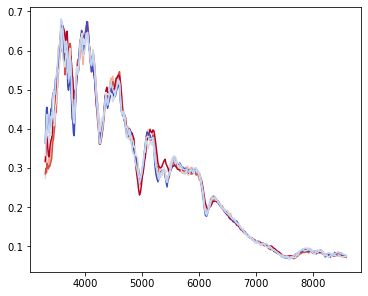

In [54]:
from matplotlib.colors import Normalize
e = a.embedding[m, 0]
norm = Normalize(np.min(e), np.max(e))

plt.figure()
for idx in np.where(m)[0]:
    plt.plot(a.wave, a.scale_flux[idx], c=plt.cm.coolwarm(norm(a.embedding[idx, 0])))

In [55]:
for i in np.where(m)[0]:
    for j in np.where(m)[0]:
        print(i, j, percentileofscore(ref_dists, dist_matrix[i, j]))

6 6 0.0
6 35 0.2688533405027557
6 42 0.8334453555585428
6 136 2.144105390509477
6 156 7.83707487565533
6 167 2.5070574001881973
6 190 5.161984137652911
35 6 0.2688533405027557
35 35 0.0
35 42 0.11426266971367119
35 136 0.947708025272214
35 156 6.674284177980911
35 167 1.1090200295738675
35 190 1.6400053770668102
42 6 0.8334453555585428
42 35 0.11426266971367119
42 42 0.0
42 136 1.781153380830757
42 156 14.665949724425326
42 167 1.8685307164941525
42 190 8.630192230138459
136 6 2.144105390509477
136 35 0.947708025272214
136 42 1.781153380830757
136 136 0.0
136 156 10.344132275843528
136 167 2.5541067347761794
136 190 2.970829412555451
156 6 7.83707487565533
156 35 6.674284177980911
156 42 14.665949724425326
156 136 10.344132275843528
156 156 0.0
156 167 1.0283640274230408
156 190 0.16803333781422233
167 6 2.5070574001881973
167 35 1.1090200295738675
167 42 1.8685307164941525
167 136 2.5541067347761794
167 156 1.0283640274230408
167 167 0.0
167 190 0.6116413496437694
190 6 5.161984137652

# Tests of SALT2 color vs RBTL color

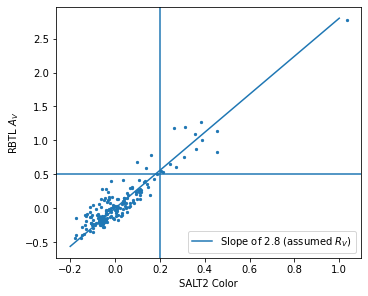

In [56]:
plt.figure()
x = a.salt_colors[a.uncertainty_mask]
y = a.rbtl_colors[a.uncertainty_mask]
plt.scatter(x, y, s=5)
plt.plot([-0.2, 1.0], [-0.2*2.8, 1.0*2.8], label='Slope of 2.8 (assumed $R_V$)')
plt.xlabel('SALT2 Color')
plt.ylabel('RBTL $A_V$')
plt.legend()
plt.axvline(0.2)
plt.axhline(0.5)

# plt.scatter(x, y - x * 2.8, s=5)